### Reload plots for the paper Li, Ruihe, Kirkaldy, Niall D., Oehler, Fabian, Marinescu, Monica, Offer, Gregory J., & O'Kane, Simon E. J. (2025). The importance of degradation mode analysis in parameterizing lifetime prediction models of lithium-ion battery degradation., which will be published soon on Nature Communications.  

### This notebook reproduce figures related to Experiment 3 (validation)

In [1]:
# magic lines that avoid re-start 
%load_ext autoreload
%autoreload 2

In [2]:
import pybamm as pb;import pandas as pd   ;import numpy as np;
import os; # import seaborn as sns
import matplotlib.pyplot as plt;import os;import imageio
from scipy.io import savemat,loadmat;from pybamm import constants,exp;
import matplotlib as mpl; fs=17; # or we can set import matplotlib.pyplot as plt then say 'mpl.rc...'
import openpyxl; import json
import traceback
import multiprocessing
import scipy.optimize
import timeit
import random;import time, signal

In [3]:
# define global index and dict for all experiment data - prepare for read!
Exp_Path = [
    "Expt 1 - Si-based Degradation",
    "Expt 2,2 - C-based Degradation 2",
    "Expt 3 - Cathode Degradation and Li-Plating",
    "Expt 4 - Drive Cycle Aging (Control)",
    "Expt 5 - Standard Cycle Aging (Control)",]
Exp_head = [
    "Expt 1",
    "Expt 2,2",
    "Expt 3",
    "Expt 4",
    "Expt 5",]
Exp_1_Cell = ["A","B","J","D","E","F","K","L","M"];
Exp_1_Temp = {
    "A":"10","B":"10","J":"10",
    "D":"25","E":"25","F":"25",
    "K":"40","L":"40","M":"40",}
Temp_Cell_Exp_1 = {
    "10":["A","B","J"],
    "25":["D","E","F"],
    "40":["K","L","M"],}
Exp_2_Cell = ["A","B","C","D","E","F"];
Exp_2_Temp = {
    "A":"10","B":"10",
    "C":"25","D":"25",
    "E":"40","F":"40",}
Temp_Cell_Exp_2 = {
    "10":["A","B"],
    "25":["C","D"],
    "40":["E","F"],}
Exp_3_Cell = ["A","B","C","D","E","F","G","H","I"];
Exp_3_Temp = {
    "A":"10","B":"10","C":"10",
    "D":"25","E":"25","F":"25",
    "G":"40","H":"40","I":"40"}
Temp_Cell_Exp_3 = {
    "10":["A","B","C"],
    "25":["D","E","F"],
    "40":["G","H","I"],}
Exp_4_Cell = ["A","B","C","D","E","F","G","H"];
Exp_4_Temp = {
    "A":"10","B":"10","C":"10",
    "D":"25","E":"25",
    "F":"40","G":"40","H":"40",}
Temp_Cell_Exp_4 = {
    "10":["A","B","C"],
    "25":["D","E",],
    "40":["F","G","H"],}
Exp_5_Cell = ["A","B","C","D","E","F","G","H"];
Exp_5_Temp = {
    "A":"10","B":"10","C":"10",
    "D":"25","E":"25",
    "F":"40","G":"40","H":"40",}
Temp_Cell_Exp_5 = {
    "10":["A","B","C"],
    "25":["D","E",],
    "40":["F","G","H"],}
Exp_All_Cell  = [Exp_1_Cell,Exp_2_Cell,Exp_3_Cell,Exp_4_Cell,Exp_5_Cell]
Exp_Temp_Cell = [Exp_1_Temp,Exp_2_Temp,Exp_3_Temp,Exp_4_Temp,Exp_5_Temp]
Temp_Cell_Exp_All = [Temp_Cell_Exp_1,Temp_Cell_Exp_2,Temp_Cell_Exp_3,Temp_Cell_Exp_4,Temp_Cell_Exp_5]
Mark_Cell_All = [
    {
    "A":"o","B":">","J":"v",
    "D":"o","E":">","F":"v",
    "K":"o","L":">","M":"v",},
    {
    "A":"10","B":"10",
    "C":"25","D":"25",
    "E":"40","F":"40",},
    {
    "A":"o","B":">","C":"v",
    "D":"o","E":">","F":"v",
    "G":"o","H":">","I":"v",},
    {
    "A":"o","B":">","C":"v",
    "D":"o","E":">",
    "F":"o","G":">","H":"v",},
    {
    "A":"o","B":">","C":"v",
    "D":"o","E":">",
    "F":"o","G":">","H":"v",}]
Color_Cell_All = [
    {
    "A":[2/255, 3/255, 226/255,0.7],"B":[2/255, 3/255, 226/255,0.7],"J":[2/255, 3/255, 226/255,0.7],
    "D":[0, 0, 0,0.7],"E":[0, 0, 0,0.7],"F":[0, 0, 0,0.7],
    "K":[1,0,0,0.4],"L":[1,0,0,0.4],"M":[1,0,0,0.4],},
    {
    "A":[2/255, 3/255, 226/255,0.7],"B":[2/255, 3/255, 226/255,0.7],
    "D":[0, 0, 0,0.7],"C":[0, 0, 0,0.7],
    "E":[1,0,0,0.4],"F":[1,0,0,0.4],},
    {
    "A":[2/255, 3/255, 226/255,0.7],"B":[2/255, 3/255, 226/255,0.7],"C":[2/255, 3/255, 226/255,0.7],
    "D":[0, 0, 0,0.7],"E":[0, 0, 0,0.7],"F":[0, 0, 0,0.7],
    "G":[1,0,0,0.4],"H":[1,0,0,0.4],"I":[1,0,0,0.4],},
    {
    "A":[2/255, 3/255, 226/255,0.7],"B":[2/255, 3/255, 226/255,0.7],"C":[2/255, 3/255, 226/255,0.7],
    "D":[0, 0, 0,0.7],"E":[0, 0, 0,0.7],
    "F":[1,0,0,0.4],"G":[1,0,0,0.4],"H":[1,0,0,0.4],},
    {
    "A":[2/255, 3/255, 226/255,0.7],"B":[2/255, 3/255, 226/255,0.7],"C":[2/255, 3/255, 226/255,0.7],
    "D":[0, 0, 0,0.7],"E":[0, 0, 0,0.7],
    "F":[1,0,0,0.4],"G":[1,0,0,0.4],"H":[1,0,0,0.4],}]


In [4]:
# ready experiment data
import sys  
str_path_0 = os.path.abspath(os.path.join(pb.__path__[0],'..'))
str_path_1 = os.path.abspath(os.path.join(str_path_0,"Reproduce_Li2024"))
sys.path.append(str_path_1) 
from Fun_NC import * # directly do this for HPC
# Load Niall's data
str_path_3 = os.path.abspath(os.path.join(pb.__path__[0],'..\\..'))
Path_NiallDMA = os.path.abspath(os.path.join(str_path_3,"SimSave\\InputData\\"))
Exp_no = 3
Temp_Cell_Exp3 = Temp_Cell_Exp_All[Exp_no-1] 
Exp_3_AllData = Read_Exp(
    Path_NiallDMA,Exp_All_Cell[Exp_no-1],
    Exp_Path,Exp_head,Exp_Temp_Cell[Exp_no-1],
    Exp_no-1)

Finish reading Experiment!


In [5]:
import pickle
def Read_Model_BestFit(Path_to_Results, purpose_i, Pick, Re_No):
    purpose = f"{purpose_i}_Case_{Pick}_{Pick}"
    path_i = os.path.join(
        Path_to_Results,  purpose, "Mats", 
        f"{Pick}_Re_{Re_No}-midc_merge.pkl")
    # print(path_i)
    with open(path_i, 'rb') as file:
        data = pickle.load(file)
    return data

BasicPath = os.path.join(
    os.path.abspath(os.path.join(pb.__path__[0],'..\\..')), 
    'SimSave', 'Li2024_Results', 'Save_LongRun')
purpose_i = "SEI_Exp1235_NC"
Path_to_Results = os.path.join(BasicPath, purpose_i, "Results")

SEI_Exp3_GoodFit = {}
SEI_Exp3_GoodFit["10"] = Read_Model_BestFit(Path_to_Results, purpose_i, Pick=7, Re_No=0)
SEI_Exp3_GoodFit["25"] = Read_Model_BestFit(Path_to_Results, purpose_i, Pick=8, Re_No=0)
SEI_Exp3_GoodFit["40"] = Read_Model_BestFit(Path_to_Results, purpose_i, Pick=9, Re_No=0)

In [6]:
purpose_i = "SEI_Dry_Exp1235_NC"
Path_to_Results = os.path.join(BasicPath, purpose_i, "Results")

SEIDry_Exp3_GoodFit = {}
SEIDry_Exp3_GoodFit["10"] = Read_Model_BestFit(Path_to_Results, purpose_i, Pick=7, Re_No=0)
SEIDry_Exp3_GoodFit["25"] = Read_Model_BestFit(Path_to_Results, purpose_i, Pick=8, Re_No=0)
SEIDry_Exp3_GoodFit["40"] = Read_Model_BestFit(Path_to_Results, purpose_i, Pick=9, Re_No=0)

In [7]:
purpose_i = "Full_Exp1235_NC"
Path_to_Results = os.path.join(BasicPath, purpose_i, "Results")

Full_Exp3_GoodFit = {}
Full_Exp3_GoodFit["10"] = Read_Model_BestFit(Path_to_Results, purpose_i, Pick=7, Re_No=0)
Full_Exp3_GoodFit["25"] = Read_Model_BestFit(Path_to_Results, purpose_i, Pick=8, Re_No=0)
Full_Exp3_GoodFit["40"] = Read_Model_BestFit(Path_to_Results, purpose_i, Pick=9, Re_No=0)

In [8]:
SaveFig_Path = os.path.join(
    os.path.abspath(os.path.join(pb.__path__[0],'..\\..')), 
    'SimSave', 'Li2024_Results', 'SaveFig')
Target = "R_241208Exp3"
target_folder = os.path.join(SaveFig_Path, Target)
if not os.path.exists(target_folder):
    os.makedirs(target_folder)

In [9]:
fs=7
font = {'family' : 'Arial',  'size'   : fs}
mpl.rc('font', **font)
colors = [
    (106, 61, 154, 1),        # 紫色
    (230, 159, 0, 1),        # 橙色
    (86, 180, 233, 1),       # 天蓝色
    (213, 94, 0, 1),         # 红色
]
cm_4s = [(r/255, g/255, b/255, d) for r, g, b, d in colors]
ms = 4; ps_num = 20; index_exp=2;  T_deg = 25; dpi = 1000; ls = 1

In [10]:
# 注意： Exp-2有13次RPT, Exp-3只有11次
RPT_max = 11

In [11]:
len(Full_Exp3_GoodFit[str(T_deg)][0]["CD Time [h]"])

13

figure saved to:  d:\lrhwork\model_rh\env_pbgem_nc\SimSave\Li2024_Results\SaveFig\R_241208Exp3/Supplementary Figure 16 Compare voltage - 3Ts


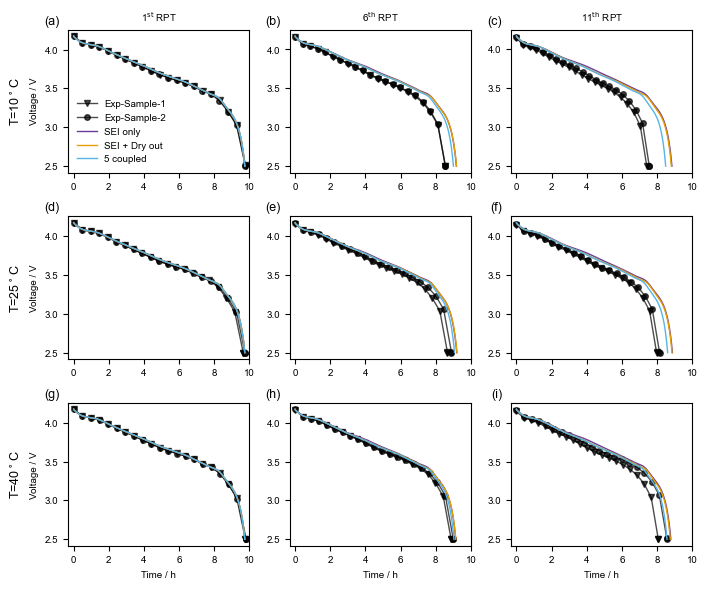

In [12]:
# Supplementary Figure 16 C/10 discharge voltage at for cells aged at 10°C (a ~ c), 25°C (d ~ f), 
# and 40°C (h ~ j) for “Experiment 3”. Note that all RPT are carried out at 25°C,
#  the temperature just denotes their ageing temperature. 
# 3 row * 3 columns; [10, 25, 40] 
def Plot_0P1C_V_3RPTs_compare_3Models_3Ts(
    SaveFig_Path,Target,index_exp,Exp_3_AllData,
    SEI_Exp3_GoodFit,SEIDry_Exp3_GoodFit,Full_Exp3_GoodFit,
    T_degs,ps_num,RPT_picks,dpi,fs,SaveFig):

    target_folder = os.path.join(SaveFig_Path, Target)
    if not os.path.exists(target_folder):
        os.makedirs(target_folder)
    ABC_labels = [f"({chr(97 + i)})" for i in range(9)]        
    fig, Axs = plt.subplots(3,3, figsize=(18/2.54, 15/2.54),tight_layout=True)
    axs = Axs.flatten()
    color_exp     = [0, 0, 0, 0.7]; marker_exps = ["v", "o"]
    for k in range(len(T_degs)):
        for i,m in enumerate(RPT_picks):
            count = 0
            for cell in Temp_Cell_Exp_All[index_exp-1][str(T_degs[k])]:
                # plot less points
                x_data = np.array(
                    Exp_3_AllData[cell]["0.1C voltage"][f"RPT{m}"]["Time (h)"]
                    ).tolist()
                y_data = np.array(
                    Exp_3_AllData[cell]["0.1C voltage"][f"RPT{m}"]["Voltage (V)"]
                    ).tolist()
                step = len(x_data) // int(ps_num) 
                x_data_sliced = x_data[::step] + [x_data[-1]]
                y_data_sliced = y_data[::step] + [y_data[-1]]
                """ if count == 0:
                    str_label = "Exp"
                else:
                    str_label = None """
                str_label = f"Exp-Sample-{count+1}"
                marker_exp = marker_exps[count]
                axs[i+k*3].plot(
                    x_data_sliced,y_data_sliced, color=color_exp,
                    marker=marker_exp, label=str_label, linewidth=ls,
                    markersize = ms )
                count += 1
            axs[i+k*3].plot(
                SEI_Exp3_GoodFit[str(T_degs[k])][0]["CD Time [h]"][m], 
                SEI_Exp3_GoodFit[str(T_degs[k])][0]["CD Terminal voltage [V]"][m],  
                '-', color = cm_4s[0],  
                linewidth=ls, label="SEI only") # SEIDry_Exp3_GoodFit["10"]
            axs[i+k*3].plot(
                SEIDry_Exp3_GoodFit[str(T_degs[k])][0]["CD Time [h]"][m], 
                SEIDry_Exp3_GoodFit[str(T_degs[k])][0]["CD Terminal voltage [V]"][m],     
                '-', color = cm_4s[1], 
                linewidth=ls, label="SEI + Dry out")
            axs[i+k*3].plot(
                Full_Exp3_GoodFit[str(T_degs[k])][0]["CD Time [h]"][m], 
                Full_Exp3_GoodFit[str(T_degs[k])][0]["CD Terminal voltage [V]"][m],     
                '-', color = cm_4s[2], 
                linewidth=ls, label="5 coupled")
    Titles = [
        r"1$^\mathrm{st}$ RPT",
        r"6$^\mathrm{th}$ RPT",
        r"11$^\mathrm{th}$ RPT",]
    for i,title in enumerate(Titles):
        axs[i+6].set_xlabel(r"Time / h") 
        axs[i*3].set_ylabel("Voltage / V")
        plt.subplots_adjust(top=0.4) 
        axs[i].set_title(title, fontsize = fs)
        axs[i*3].text(
            -0.25, 0.5, f"T={T_degs[i]}"+r"$^\circ$C", 
            verticalalignment='center', 
            horizontalalignment='right', 
            rotation='vertical', 
            transform=axs[i*3].transAxes,
            fontsize=fs+2)
    for i in range(9):
        axs[i].set_xlim(-0.3,10)
        axs[i].text(
            -0.05, 1.1, 
            ABC_labels[i], transform=axs[i].transAxes, 
            fontsize=fs+2, va='top', ha='right')
    
    axs[0].legend(prop={'size':fs},loc='best',frameon=False)
    if SaveFig == True:
        plt.savefig(
            target_folder + f"/Supplementary Figure 16 Compare voltage - 3Ts.png", 
            bbox_inches='tight', dpi=dpi) 
        plt.savefig(
            target_folder + f"/Supplementary Figure 16 Compare voltage - 3Ts.svg",
            bbox_inches='tight') 
        plt.savefig(
            target_folder + f"/Supplementary Figure 16 Compare voltage - 3Ts.pdf",
            bbox_inches='tight') 
        # plt.close() 
        print('Supplementary Figure 16 saved to: ', target_folder + f"/Supplementary Figure 16 Compare voltage - 3Ts")
    return

RPT_picks = [0, 5, 10]
T_degs = [10, 25, 40]
Plot_0P1C_V_3RPTs_compare_3Models_3Ts(
    SaveFig_Path,Target,index_exp,Exp_3_AllData,
    SEI_Exp3_GoodFit,SEIDry_Exp3_GoodFit,Full_Exp3_GoodFit,
    T_degs,ps_num,RPT_picks,dpi,fs,SaveFig=True)


In [35]:
# save data to excel: Supplementary Figure 16
# Prepare data for Excel export
data_for_excel = {}

# Collect data for Excel
for k in range(len(T_degs)):
    for i, m in enumerate(RPT_picks):
        # Get the subplot index
        subplot_index = i + k * 3
        # Prepare data for the current subplot
        subplot_data = {}
        # Collect experimental data
        count = 0
        for cell in Temp_Cell_Exp_All[index_exp - 1][str(T_degs[k])]:
            x_data = np.array(Exp_3_AllData[cell]["0.1C voltage"][f"RPT{m}"]["Time (h)"]).tolist()
            y_data = np.array(Exp_3_AllData[cell]["0.1C voltage"][f"RPT{m}"]["Voltage (V)"]).tolist()
            step = len(x_data) // int(ps_num)
            x_data_sliced = x_data[::step] + [x_data[-1]]
            y_data_sliced = y_data[::step] + [y_data[-1]]
            subplot_data[f"Time_Exp_Sample_{count + 1}"] = x_data_sliced
            subplot_data[f"Voltage_Exp_Sample_{count + 1}"] = y_data_sliced
            count += 1
        # Collect model data
        for model, color in zip(
            ["SEI_only", "SEI_Dry_out", "5_coupled"],
            [cm_4s[0], cm_4s[1], cm_4s[2]]
        ):
            if model == "SEI_only":
                x_data = SEI_Exp3_GoodFit[str(T_degs[k])][0]["CD Time [h]"][m]
                y_data = SEI_Exp3_GoodFit[str(T_degs[k])][0]["CD Terminal voltage [V]"][m]
            elif model == "SEI_Dry_out":
                x_data = SEIDry_Exp3_GoodFit[str(T_degs[k])][0]["CD Time [h]"][m]
                y_data = SEIDry_Exp3_GoodFit[str(T_degs[k])][0]["CD Terminal voltage [V]"][m]
            elif model == "5_coupled":
                x_data = Full_Exp3_GoodFit[str(T_degs[k])][0]["CD Time [h]"][m]
                y_data = Full_Exp3_GoodFit[str(T_degs[k])][0]["CD Terminal voltage [V]"][m]
            subplot_data[f"Time_{model}"] = x_data
            subplot_data[f"Voltage_{model}"] = y_data
        # Store data for the current subplot
        data_for_excel[f"fig({chr(97 + subplot_index)})"] = subplot_data

# Create an Excel writer object
excel_file_path = target_folder + "/Supplementary Figure 16 Compare voltage - 3Ts.xlsx"
with pd.ExcelWriter(excel_file_path) as writer:
    # Save each subplot's data to a separate sheet
    for sheet_name, data in data_for_excel.items():
        df = pd.DataFrame({k: pd.Series(v) for k, v in data.items()})
        df.to_excel(writer, sheet_name=sheet_name, index=False)

print(f"Supplementary Figure 16 saved to {excel_file_path}")

Supplementary Figure 16 saved to d:\lrhwork\model_rh\env_pbgem_nc\SimSave\Li2024_Results\SaveFig\R_241208Exp3/Supplementary Figure 16 Compare voltage - 3Ts.xlsx


In [14]:
def mean_percentage_error(y_true, y_pred):
    A = y_true; B =  y_pred
    if 0 in A:
        indices = np.where(A == 0)[0]
        A = np.delete(A, indices)
        B = np.delete(B, indices)
        #print(A)
    errors = np.abs(A - B) / np.abs(A)
    mpe = np.mean(errors) * 100
    return mpe
def Calculate_MPE_General(x1,x2,y1,y2):
    from scipy.interpolate import interp1d
    min_x1, max_x1 = min(x1), max(x1)
    min_x2, max_x2 = min(x2), max(x2)

    min_x = max(min_x1, min_x2)
    max_x = min(max_x1, max_x2)

    x1 = np.clip(x1, min_x, max_x)
    x2 = np.clip(x2, min_x, max_x)

    f_interp1 = interp1d(x1, y1, kind='linear', fill_value='extrapolate')
    f_interp2 = interp1d(x2, y2, kind='linear', fill_value='extrapolate')

    num_points = 500  # Adjust this based on your preference
    common_x = np.linspace(min_x, max_x, num_points)

    y1_interp = f_interp1(common_x)
    y2_interp = f_interp2(common_x)

    mpe = mean_percentage_error(y1_interp, y2_interp)
    #print(f"Mean Percentage Error (MPE): {mpe:.2f}%")
    return mpe

def Calculate_0P1C_V_MPE(
        index_exp,Exp_3_AllData,
        case_i,  T_deg,m):
    Cells = Temp_Cell_Exp_All[index_exp-1][str(T_deg)]
    mpe_all = []
    for cell in Cells:
        x_true = np.array(
            Exp_3_AllData[cell]["0.1C voltage"][f"RPT{m}"]["Time (h)"]).tolist()
        y_true = np.array(
            Exp_3_AllData[cell]["0.1C voltage"][f"RPT{m}"]["Voltage (V)"]).tolist()
        x_model = case_i[str(T_deg)][0]["CD Time [h]"][m]
        y_model = case_i[str(T_deg)][0]["CD Terminal voltage [V]"][m]
        mpe_all .append( Calculate_MPE_General(x_true,x_model,y_true,y_model)  )
    mep_avg = sum(mpe_all) / len(mpe_all)
    return mep_avg

Cases = [SEI_Exp3_GoodFit,SEIDry_Exp3_GoodFit,Full_Exp3_GoodFit]; 
Str_cases = ["SEI only","SEI + Dry out","5 coupled",]
index_exp = 2;  T_deg_All = [10,25,40] ; i_RPT=0
V_MPE_All = {}
for i,case in enumerate(Cases):
    V_MPE_All[Str_cases[i]] = {}
    for T_deg in T_deg_All:
        V_MPE_All[Str_cases[i]] [T_deg] = []

for i,case in enumerate(Cases):
    for T_deg in T_deg_All:
        for i_RPT in range(RPT_max):
            V_MPE_All[Str_cases[i]][T_deg].append(Calculate_0P1C_V_MPE(
                index_exp,Exp_3_AllData,
                Cases[i],T_deg,i_RPT)  )
i=0; T_deg=10
#print(f"{Str_cases[i]}, T={T_deg}degC")
#plt.plot( V_MPE_All[Str_cases[i]][T_deg])
""" fig, axs = plt.subplots(
    1,3, figsize=(18/2.54,5/2.54),
    gridspec_kw={'top': 0.9, 'bottom': 0.15}
    )
ABC_labels = ["(a)", "(b)", "(c)"]
for i_ax,T_deg in enumerate(T_deg_All):
    for j in range(len(Str_cases)):
        axs[i_ax].plot(V_MPE_All[Str_cases[j]][T_deg],  
            '-', color=cm_4s[j],  
            linewidth=ls,
            label=Str_cases[j]) 
        axs[i_ax].set_xlabel(r"RPT number") 
        axs[i_ax].set_ylim([0.2,1.3])
        axs[i_ax].set_xticks([0,3,6,9,11])
        axs[i_ax].set_title(f"T={T_deg}"+r"$^\circ$C",fontsize = fs)
    if i_ax == 0:
        axs[i_ax].legend(loc='best',frameon=False)
        axs[i_ax].set_ylabel("MPE / %")
    axs[i_ax].text(
        -0.1, 1.1, 
        ABC_labels[i_ax], transform=axs[i_ax].transAxes, 
        fontsize=fs, va='top', ha='right')
plt.savefig(
    target_folder + f"/Fig. S5 (a~c) - MPE All 3Ts.png", 
    bbox_inches='tight', dpi=dpi)
plt.savefig(
    target_folder + f"/Fig. S5 (a~c) - MPE All 3Ts.pdf",
    bbox_inches='tight') """
print('Table S10 in SI:')
print()
print('Average MPEs of Exp-3:')
for j in range(len(Str_cases)):
    for i_ax,T_deg in enumerate(T_deg_All):

        print(f"T={T_deg},{Str_cases[j]}:{np.mean(V_MPE_All[Str_cases[j]][T_deg]):.2f}")
print()
print('Standard deviation of MPEs of Exp-3:')
for j in range(len(Str_cases)):
    for i_ax,T_deg in enumerate(T_deg_All):

        print(f"T={T_deg},{Str_cases[j]}:{np.std(V_MPE_All[Str_cases[j]][T_deg]):.2f}")

Table S10 in SI:

Average MPEs of Exp-3:
T=10,SEI only:2.80
T=25,SEI only:1.96
T=40,SEI only:1.41
T=10,SEI + Dry out:2.63
T=25,SEI + Dry out:1.80
T=40,SEI + Dry out:1.22
T=10,5 coupled:2.45
T=25,5 coupled:1.59
T=40,5 coupled:1.01

Standard deviation of MPEs of Exp-3:
T=10,SEI only:1.42
T=25,SEI only:0.78
T=40,SEI only:0.69
T=10,SEI + Dry out:1.31
T=25,SEI + Dry out:0.68
T=40,SEI + Dry out:0.58
T=10,5 coupled:1.25
T=25,5 coupled:0.57
T=40,5 coupled:0.45


In [15]:
# calculate RMSE:
def Calculate_RMSE_General(x1,x2,y1,y2):
    from scipy.interpolate import interp1d
    min_x1, max_x1 = min(x1), max(x1)
    min_x2, max_x2 = min(x2), max(x2)

    min_x = max(min_x1, min_x2)
    max_x = min(max_x1, max_x2)

    x1 = np.clip(x1, min_x, max_x)
    x2 = np.clip(x2, min_x, max_x)

    f_interp1 = interp1d(x1, y1, kind='linear', fill_value='extrapolate')
    f_interp2 = interp1d(x2, y2, kind='linear', fill_value='extrapolate')

    num_points = 500  # Adjust this based on your preference
    common_x = np.linspace(min_x, max_x, num_points)

    y1_interp = f_interp1(common_x)
    y2_interp = f_interp2(common_x)

    RMSE =  np.sqrt(np.mean((y1_interp - y2_interp)**2)) 
    #print(f"Mean Percentage Error (MPE): {mpe:.2f}%")
    return RMSE

def Calculate_0P1C_V_RMSE(
        index_exp,Exp_3_AllData,
        case_i,  T_deg,m):
    Cells = Temp_Cell_Exp_All[index_exp-1][str(T_deg)]
    rmse_all = []
    for cell in Cells:
        x_true = np.array(
            Exp_3_AllData[cell]["0.1C voltage"][f"RPT{m}"]["Time (h)"]).tolist()
        y_true = np.array(
            Exp_3_AllData[cell]["0.1C voltage"][f"RPT{m}"]["Voltage (V)"]).tolist()
        x_model = case_i[str(T_deg)][0]["CD Time [h]"][m]
        y_model = case_i[str(T_deg)][0]["CD Terminal voltage [V]"][m]
        rmse_all .append( Calculate_RMSE_General(x_true,x_model,y_true,y_model)  )
    rmse_avg = sum(rmse_all) / len(rmse_all)
    return rmse_avg

V_RMSE_All = {}
for i,case in enumerate(Cases):
    V_RMSE_All[Str_cases[i]] = {}
    for T_deg in T_deg_All:
        V_RMSE_All[Str_cases[i]] [T_deg] = []

for i,case in enumerate(Cases):
    for T_deg in T_deg_All:
        for i_RPT in range(RPT_max):
            V_RMSE_All[Str_cases[i]][T_deg].append(Calculate_0P1C_V_RMSE(
                index_exp,Exp_3_AllData,
                Cases[i],T_deg,i_RPT)  )
i=0; T_deg=10
#print(f"{Str_cases[i]}, T={T_deg}degC")
#plt.plot( V_RMSE_All[Str_cases[i]][T_deg])
""" fig, axs = plt.subplots(
    1,3, figsize=(18/2.54,5/2.54),
    gridspec_kw={'top': 0.9, 'bottom': 0.15}
    )
ABC_labels = ["(a)", "(b)", "(c)"]
for i_ax,T_deg in enumerate(T_deg_All):
    for j in range(len(Str_cases)):
        axs[i_ax].plot(    np.array(V_RMSE_All[Str_cases[j]][T_deg]) * 1E3,  
            '-', color=cm_4s[j],  
            #linestyle=LS[0],
            label=Str_cases[j]) 
        axs[i_ax].set_xlabel(r"RPT number") 
        axs[i_ax].set_ylim([0,55])
        axs[i_ax].set_xticks([0,3,6,9,11])
        axs[i_ax].set_title(f"T={T_deg}"+r"$^\circ$C", fontsize = fs)
    if i_ax == 0:
        axs[i_ax].legend(prop={'size':fs-2},loc='best',frameon=False)
        axs[i_ax].set_ylabel("RMSE / mV") """
""" plt.savefig(target_folder + f"/Fig. S5 (d~f) - RMSE All 3Ts.png",
            bbox_inches='tight', dpi=dpi)
plt.savefig(target_folder + f"/Fig. S5 (d~f) - RMSE All 3Ts.pdf",
            bbox_inches='tight') """
print('Table S11 in SI:')
print()
print('Average RMSEs of Exp-3:')
for j in range(len(Str_cases)):
    for i_ax,T_deg in enumerate(T_deg_All):
        rmse_i = np.mean(V_RMSE_All[Str_cases[j]][T_deg]) * 1E3
        print(f"T={T_deg},{Str_cases[j]}:{rmse_i:.2f}")
print()
print('Standard deviation of RMSEs of Exp-3:')
for j in range(len(Str_cases)):
    for i_ax,T_deg in enumerate(T_deg_All):
        std_i = np.std(V_RMSE_All[Str_cases[j]][T_deg]) * 1E3
        print(f"T={T_deg},{Str_cases[j]}:{std_i:.2f}")

Table S11 in SI:

Average RMSEs of Exp-3:
T=10,SEI only:124.58
T=25,SEI only:89.35
T=40,SEI only:62.17
T=10,SEI + Dry out:119.96
T=25,SEI + Dry out:85.64
T=40,SEI + Dry out:56.49
T=10,5 coupled:109.42
T=25,5 coupled:72.58
T=40,5 coupled:44.20

Standard deviation of RMSEs of Exp-3:
T=10,SEI only:62.42
T=25,SEI only:36.86
T=40,SEI only:31.09
T=10,SEI + Dry out:58.57
T=25,SEI + Dry out:33.49
T=40,SEI + Dry out:27.59
T=10,5 coupled:55.22
T=25,5 coupled:27.54
T=40,5 coupled:19.81


Supplementary Figure 15 saved to d:\lrhwork\model_rh\env_pbgem_nc\SimSave\Li2024_Results\SaveFig\R_241208Exp3\Supplementary Figure 15.xlsx


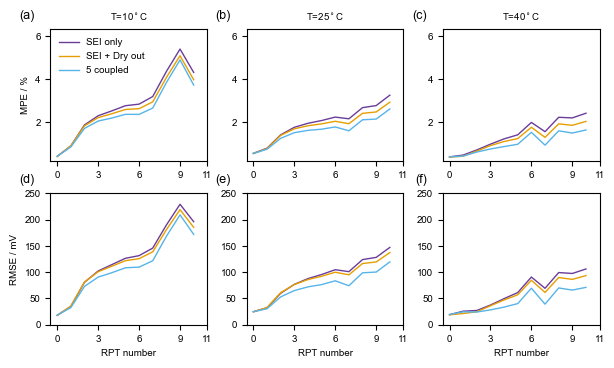

In [38]:
# 合并画：Supplementary Figure 15 (a~f) - MPE and RMSE for All 3Ts  for “Experiment 3”.
# Supplementary Figure 15 MPE (a ~ c) and RMSE (d ~ e) of C/10 voltage during RPTs for “Experiment 3”.
fig, Axs = plt.subplots(
    2,3, figsize=(18/2.54,10/2.54),
    gridspec_kw={'top': 0.9, 'bottom': 0.15}
    )
axs = Axs.flatten()
ABC_labels = [
    "(a)", "(b)", "(c)",
    "(d)", "(e)", "(f)"]

# 定义Excel文件路径
excel_file_path = os.path.join(target_folder, "Supplementary Figure 15.xlsx")
data_for_excel = {}


for i_ax,T_deg in enumerate(T_deg_All):
    dict_fig_i_ax={}
    for j in range(len(Str_cases)):
        axs[i_ax].plot(V_MPE_All[Str_cases[j]][T_deg],  
            '-', color=cm_4s[j],  
            linewidth=ls,
            label=Str_cases[j]) 
        dict_fig_i_ax[f'RPT_number_{Str_cases[j]}'] = range(len(V_MPE_All[Str_cases[j]][T_deg]))
        dict_fig_i_ax["MPE"] = V_MPE_All[Str_cases[j]][T_deg]
        #axs[i_ax].set_xlabel(r"RPT number") 
        axs[i_ax].set_ylim([0.2,6.3])
        axs[i_ax].set_xticks([0,3,6,9,11])
        axs[i_ax].set_title(f"T={T_deg}"+r"$^\circ$C",fontsize = fs)
    if i_ax == 0:
        axs[i_ax].legend(loc='best',frameon=False)
        axs[i_ax].set_ylabel("MPE / %")
    # transfer data to Excel 
    df_fig_i_ax = pd.DataFrame.from_dict(dict_fig_i_ax, orient='index').T
    data_for_excel[f"fig({ABC_labels[i_ax]})"] = df_fig_i_ax

    axs[i_ax].text(
        -0.1, 1.15, 
        ABC_labels[i_ax], transform=axs[i_ax].transAxes, 
        fontsize=fs+2, va='top', ha='right')
for i_ax,T_deg in enumerate(T_deg_All):
    i_ax = i_ax + 3
    dict_fig_i_ax={}
    for j in range(len(Str_cases)):
        axs[i_ax].plot(np.array(V_RMSE_All[Str_cases[j]][T_deg]) * 1E3,  
            '-', color=cm_4s[j],  
            linewidth=ls,
            #linestyle=LS[0],
            label=Str_cases[j]) 
        dict_fig_i_ax[f'RPT_number_{Str_cases[j]}'] = range(len(V_RMSE_All[Str_cases[j]][T_deg]))
        dict_fig_i_ax["RMSE"] = np.array(V_RMSE_All[Str_cases[j]][T_deg]) * 1E3
        axs[i_ax].set_xlabel(r"RPT number") 
        axs[i_ax].set_ylim([0,250])
        axs[i_ax].set_xticks([0,3,6,9,11])
        #axs[i_ax].set_title(f"T={T_deg}"+r"$^\circ$C", fontsize = fs)
    if i_ax == 0+3:
        axs[i_ax].set_ylabel("RMSE / mV")
    # transfer data to Excel 
    df_fig_i_ax = pd.DataFrame.from_dict(dict_fig_i_ax, orient='index').T
    data_for_excel[f"fig({ABC_labels[i_ax]})"] = df_fig_i_ax

    axs[i_ax].text(
        -0.1, 1.15, 
        ABC_labels[i_ax], transform=axs[i_ax].transAxes, 
        fontsize=fs+2, va='top', ha='right')
plt.subplots_adjust(wspace=0.25, hspace=0.25)
plt.savefig(
    target_folder + f"/Supplementary Figure 15 (a~f) - MPE and RMSE for All 3Ts.png", 
    bbox_inches='tight', dpi=dpi)
plt.savefig(
    target_folder + f"/Supplementary Figure 15 (a~f) - MPE and RMSE for All 3Ts.pdf",
    bbox_inches='tight')  


# 保存到Excel文件
with pd.ExcelWriter(excel_file_path) as writer:
    for sheet_name, data in data_for_excel.items():
        df = pd.DataFrame(data)
        df.to_excel(writer, sheet_name=sheet_name, index=False)

print(f"Supplementary Figure 15 saved to {excel_file_path}")


In [36]:
# save excel: Supplementary Figure 15
data_for_excel = {}

# Collect data for Excel
for i_ax, T_deg in enumerate(T_deg_All):
    # Prepare data for the current subplot (MPE)
    subplot_data_MPE = {}
    for j, case in enumerate(Str_cases):
        subplot_data_MPE[f"RPT_number_MPE_{case}"] = list(range(len(V_MPE_All[case][T_deg])))
        subplot_data_MPE[f"MPE_{case}"] = V_MPE_All[case][T_deg]
    # Store data for the current subplot (MPE)
    data_for_excel[f"fig({chr(97 + i_ax)})"] = subplot_data_MPE

    # Prepare data for the current subplot (RMSE)
    subplot_data_RMSE = {}
    for j, case in enumerate(Str_cases):
        subplot_data_RMSE[f"RPT_number_RMSE_{case}"] = list(range(len(V_RMSE_All[case][T_deg])))
        subplot_data_RMSE[f"RMSE_{case}"] = np.array(V_RMSE_All[case][T_deg]) * 1E3
    # Store data for the current subplot (RMSE)
    data_for_excel[f"fig({chr(97 + i_ax + 3)})"] = subplot_data_RMSE

# Create an Excel writer object
excel_file_path = target_folder + "/Supplementary Figure 15 (a~f) - MPE and RMSE for All 3Ts.xlsx"
with pd.ExcelWriter(excel_file_path) as writer:
    # Save each subplot's data to a separate sheet
    for sheet_name, data in data_for_excel.items():
        df = pd.DataFrame(data)
        df.to_excel(writer, sheet_name=sheet_name, index=False)

print(f"Data saved to {excel_file_path}")

Data saved to d:\lrhwork\model_rh\env_pbgem_nc\SimSave\Li2024_Results\SaveFig\R_241208Exp3/Supplementary Figure 15 (a~f) - MPE and RMSE for All 3Ts.xlsx


' plt.savefig(\n    target_folder + f"/Fig.3 - Fit SOH and Resistance.png", dpi=dpi)\nplt.savefig(\n    target_folder + f"/Fig.3 - Fit SOH and Resistance.pdf")  '

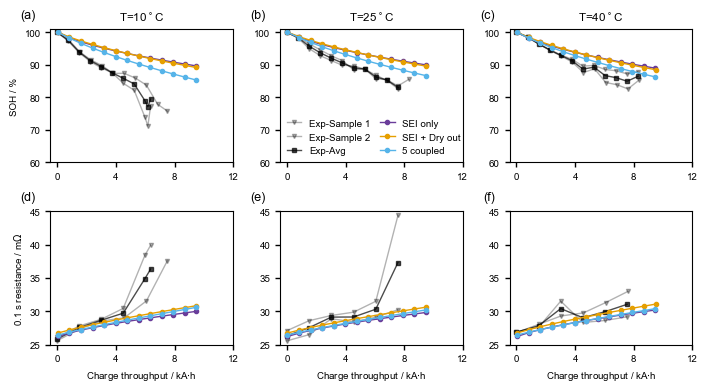

In [18]:
m = 3
# Fig. 3 -  Validate SOH and Lump resistance for 3 Ts and 3 models
color_exp     = [0, 0, 0, 0.3]; marker_exp     = "v";
color_exp_Avg = [0, 0, 0, 0.7]; marker_exp_Avg = "s";
index_exp = 2; Exp_Any_AllData = Exp_3_AllData; 
Temp_Cell_Exp = Temp_Cell_Exp_All[index_exp-1] 

fig, axs = plt.subplots(2,3, figsize=(18/2.54,10/2.54),tight_layout=True) 
j=0
for i,T_deg in enumerate([10,25,40]):
    Exp_temp_i_cell = Temp_Cell_Exp[str(int(T_deg))]
    XY_pack = Get_Cell_Mean_1T_1Exp(Exp_Any_AllData,Exp_temp_i_cell) 
    [X_1_st,X_5_st,Y_1_st_avg,Y_2_st_avg,
        Y_3_st_avg,Y_4_st_avg,Y_5_st_avg,Y_6_st_avg]  = XY_pack
    for m, cell in enumerate(Exp_temp_i_cell):
        df = Exp_Any_AllData[cell]["Extract Data"]
        chThr_temp = np.array(df["Charge Throughput (A.h)"])/1e3
        df_DMA = Exp_Any_AllData[cell]["DMA"]["LLI_LAM"]
        axs[j,i].plot(
            chThr_temp,np.array(df_DMA["SoH"])*100,
            color=color_exp,marker=marker_exp,linewidth=ls,
            markersize = ms, label=f"Exp-Sample {m+1}" ) # 
    axs[j,i].plot(
        X_1_st,Y_1_st_avg,color=color_exp_Avg,
        linewidth=ls, markersize = ms,
        marker=marker_exp_Avg,label=f"Exp-Avg") 
    for k,case in enumerate(Cases):
        axs[j,i].plot(
            case[str(T_deg)][0]['Throughput capacity [kA.h]'], 
            case[str(T_deg)][0]['CDend SOH [%]'], 
            linewidth=ls, marker = 'o', markersize = ms,
            color = cm_4s[k], label=Str_cases[k])
    axs[j,i].set_ylim(60,101)
    axs[j,i].set_xticks([0,4,8,12])
    #axs[j,i].set_yticks([88,92,96,100])
    axs[j,i].set_title(f"T={T_deg}"+r"$^\circ$C")
axs[j,0].set_ylabel("SOH / %")
axs[j,1].legend(
    prop={'size':fs},loc='best',frameon=False,
    ncol=2, markerscale=1, borderpad=0.2,
    handlelength=1.5,columnspacing=1)
for k in range(3):
    labels = axs[j,k].get_xticklabels() + axs[j,k].get_yticklabels()
    axs[j,k].tick_params(labelcolor='k', labelsize=fs, width=1);del labels  
j = 1
for i,T_deg in enumerate([10,25,40]):
    Exp_temp_i_cell = Temp_Cell_Exp[str(int(T_deg))]
    XY_pack = Get_Cell_Mean_1T_1Exp(Exp_Any_AllData,Exp_temp_i_cell) 
    [X_1_st,X_5_st,Y_1_st_avg,Y_2_st_avg,
        Y_3_st_avg,Y_4_st_avg,Y_5_st_avg,Y_6_st_avg]  = XY_pack
    for cell in Exp_temp_i_cell:
        df = Exp_Any_AllData[cell]["Extract Data"]
        chThr_temp = np.array(df["Charge Throughput (A.h)"])/1e3
        df_DMA = Exp_Any_AllData[cell]["DMA"]["LLI_LAM"]
        index_Res = df[df['0.1s Resistance (Ohms)'].le(10)].index
        axs[j,i].plot(
            np.array(df["Charge Throughput (A.h)"][index_Res])/1e3,
            np.array(df["0.1s Resistance (Ohms)"][index_Res])*1e3,
            color=color_exp,marker=marker_exp,
            linewidth=ls, markersize = ms,)
    axs[j,i].plot(
        X_5_st,Y_5_st_avg,color=color_exp_Avg,
        marker=marker_exp_Avg,label=f"Exp-Avg",
        linewidth=ls, markersize = ms,) 
    for k,case in enumerate(Cases):
        axs[j,i].plot(
            case[str(T_deg)][0]["Throughput capacity [kA.h]"], 
            np.array(case[str(T_deg)][0]["Res_midSOC"]), 
            linewidth=ls, marker = 'o', markersize = ms,
            color = cm_4s[k], label=Str_cases[k])
    axs[j,i].set_xlabel(r"Charge throughput / kA$\cdot$h")
    axs[j,i].set_ylim(25,45)
    axs[j,i].set_xticks([0,4,8,12]);
axs[j,0].set_ylabel(r"0.1 s resistance / m$\Omega$")
for k in range(3):
    labels = axs[j,k].get_xticklabels() + axs[j,k].get_yticklabels()
    axs[j,k].tick_params(labelcolor='k', labelsize=fs, width=1);del labels  
labels = [f"({chr(97 + i)})" for i in range(6)]
axs_i = axs.flatten()
for i in range(6):   
    axs_i[i].text(
        -0.08, 1.15, 
        labels[i], transform=axs_i[i].transAxes, 
        fontsize=fs+2,  # fontweight='bold', 
        va='top', ha='right')
plt.subplots_adjust(wspace=0.18, hspace=0.18)
""" plt.savefig(
    target_folder + f"/Fig.3 - Fit SOH and Resistance.png", dpi=dpi)
plt.savefig(
    target_folder + f"/Fig.3 - Fit SOH and Resistance.pdf")  """

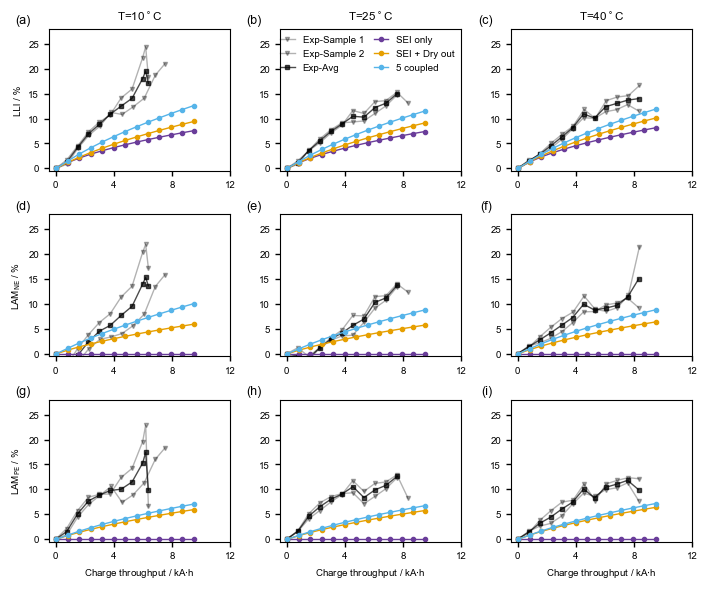

In [19]:
# Fig. 4 - DMA - LLI, LAM_Ne, LAM_Pe
fig, axs = plt.subplots(3,3, figsize=(18/2.54,15/2.54),tight_layout=True) 
j=0
for i,T_deg in enumerate([10,25,40]):
    Exp_temp_i_cell = Temp_Cell_Exp[str(int(T_deg))]
    XY_pack = Get_Cell_Mean_1T_1Exp(Exp_Any_AllData,Exp_temp_i_cell) 
    [X_1_st,X_5_st,Y_1_st_avg,Y_2_st_avg,
        Y_3_st_avg,Y_4_st_avg,Y_5_st_avg,Y_6_st_avg]  = XY_pack
    for m, cell in enumerate(Exp_temp_i_cell):
        df = Exp_Any_AllData[cell]["Extract Data"]
        chThr_temp = np.array(df["Charge Throughput (A.h)"])/1e3
        df_DMA = Exp_Any_AllData[cell]["DMA"]["LLI_LAM"]
        axs[j,i].plot(
            chThr_temp,np.array(df_DMA["LLI"])*100,
            color=color_exp,marker=marker_exp,
            linewidth=ls, markersize = ms,label=f"Exp-Sample {m+1}" ) # 
    axs[j,i].plot(
        X_1_st,Y_2_st_avg,color=color_exp_Avg,
        marker=marker_exp_Avg, label=f"Exp-Avg",
        linewidth=ls, markersize = ms,) 
    for k,case in enumerate(Cases):
        axs[j,i].plot(
            case[str(T_deg)][0]['Throughput capacity [kA.h]'], 
            case[str(T_deg)][0]['CDend LLI [%]'], 
            linewidth=ls, marker = 'o', markersize = ms,
            color = cm_4s[k], label=Str_cases[k])
    axs[j,i].set_ylim(-0.5,28)
    axs[j,i].set_xticks([0,4,8,12])
    axs[j,i].set_title(f"T={T_deg}"+r"$^\circ$C")
axs[j,0].set_ylabel("LLI / %")

for k in range(3):
    labels = axs[j,k].get_xticklabels() + axs[j,k].get_yticklabels()
    axs[j,k].tick_params(labelcolor='k', labelsize=fs, width=1);del labels  
j = 1
for i,T_deg in enumerate([10,25,40]):
    Exp_temp_i_cell = Temp_Cell_Exp[str(int(T_deg))]
    XY_pack = Get_Cell_Mean_1T_1Exp(Exp_Any_AllData,Exp_temp_i_cell) 
    [X_1_st,X_5_st,Y_1_st_avg,Y_2_st_avg,
        Y_3_st_avg,Y_4_st_avg,Y_5_st_avg,Y_6_st_avg]  = XY_pack
    for cell in Exp_temp_i_cell:
        df = Exp_Any_AllData[cell]["Extract Data"]
        chThr_temp = np.array(df["Charge Throughput (A.h)"])/1e3
        df_DMA = Exp_Any_AllData[cell]["DMA"]["LLI_LAM"]
        axs[j,i].plot(
            chThr_temp, np.array(df_DMA["LAM NE_tot"])*100,
            color=color_exp,marker=marker_exp,
            linewidth=ls, markersize = ms,)
    axs[j,i].plot(
        X_1_st,Y_3_st_avg,color=color_exp_Avg,
        marker=marker_exp_Avg,label=f"Exp-Avg",
        linewidth=ls, markersize = ms) 
    for k,case in enumerate(Cases):
        axs[j,i].plot(
            case[str(T_deg)][0]["Throughput capacity [kA.h]"], 
            np.array(case[str(T_deg)][0]["CDend LAM_ne [%]"]), 
            linewidth=ls, marker = 'o', markersize = ms,
            color = cm_4s[k], label=Str_cases[k])
    axs[j,i].set_ylim(-0.5,28)
    axs[j,i].set_xticks([0,4,8,12])
axs[j,0].set_ylabel(r"LAM$_\mathrm{NE}$ / %")
for k in range(3):
    labels = axs[j,k].get_xticklabels() + axs[j,k].get_yticklabels()
    axs[j,k].tick_params(labelcolor='k', labelsize=fs, width=1);del labels  
j = 2
for i,T_deg in enumerate([10,25,40]):
    Exp_temp_i_cell = Temp_Cell_Exp[str(int(T_deg))]
    XY_pack = Get_Cell_Mean_1T_1Exp(Exp_Any_AllData,Exp_temp_i_cell) 
    [X_1_st,X_5_st,Y_1_st_avg,Y_2_st_avg,
        Y_3_st_avg,Y_4_st_avg,Y_5_st_avg,Y_6_st_avg]  = XY_pack
    for m,cell in enumerate(Exp_temp_i_cell):
        df = Exp_Any_AllData[cell]["Extract Data"]
        chThr_temp = np.array(df["Charge Throughput (A.h)"])/1e3
        df_DMA = Exp_Any_AllData[cell]["DMA"]["LLI_LAM"]
        axs[j,i].plot(
            chThr_temp, np.array(df_DMA["LAM PE"])*100,
            color=color_exp, marker=marker_exp,
            linewidth=ls, markersize = ms, label=f"Exp-Sample {m+1}" ) # 
    axs[j,i].plot(
        X_1_st,Y_4_st_avg,color=color_exp_Avg,
        marker=marker_exp_Avg,label=f"Exp-Avg",
        linewidth=ls, markersize = ms,) 
    for k,case in enumerate(Cases):
        axs[j,i].plot(
            case[str(T_deg)][0]["Throughput capacity [kA.h]"], 
            np.array(case[str(T_deg)][0]["CDend LAM_pe [%]"]), 
            linewidth=ls, marker = 'o', markersize = ms,
            color = cm_4s[k], label=Str_cases[k])
    axs[j,i].set_xlabel(r"Charge throughput / kA$\cdot$h")
    axs[j,i].set_ylim(-0.5,28)
    axs[j,i].set_xticks([0,4,8,12]);
axs[j,0].set_ylabel(r"LAM$_\mathrm{PE}$ / %")
for k in range(3):
    labels = axs[j,k].get_xticklabels() + axs[j,k].get_yticklabels()
    axs[j,k].tick_params(labelcolor='k', labelsize=fs, width=1);del labels  
labels = [f"({chr(97 + i)})" for i in range(9)]
axs_i = axs.flatten()
for i in range(9):   
    axs_i[i].text(
        -0.10, 1.10, 
        labels[i], transform=axs_i[i].transAxes, 
        fontsize=fs+2,  # fontweight='bold', 
        va='top', ha='right')

axs_i[1].legend(
    prop={'size':fs},loc='best',frameon=False,
    ncol=2, markerscale=1, borderpad=0.2,
    handlelength=1.5,columnspacing=1)
plt.savefig(
    target_folder + f"/Fig.4 - Fit DMA-1 of Exp-3.png", dpi=dpi)
plt.savefig(
    target_folder + f"/Fig.4 - Fit DMA-1 of Exp-3.pdf")  

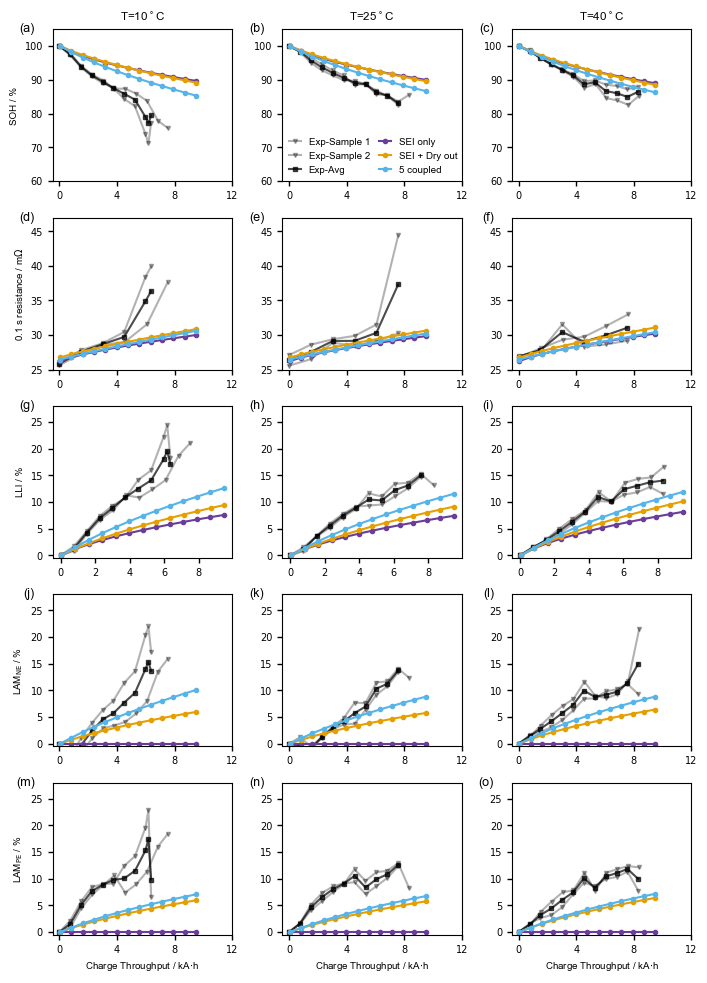

In [20]:
# Fig. 6 - Validation of the three models against “Experimnt 3”. 
# (a~c) SOH, (d ~ f) 0.1 s resistance, (g~i) LLI, (j~l) LAMNE, (m~o) LAMPE. 
# Each row represnets the same indices and each column corresponds to
#  the same temeperature. 
color_exp     = [0, 0, 0, 0.3]; marker_exp     = "v";
color_exp_Avg = [0, 0, 0, 0.7]; marker_exp_Avg = "s";
Exp_Any_AllData = Exp_3_AllData; 
Temp_Cell_Exp = Temp_Cell_Exp_All[index_exp-1] 

# fig, Axs = plt.subplots(5,3, figsize=(16.5,18),tight_layout=True) 
fig, Axs = plt.subplots(5,3, figsize=(18/2.54,25/2.54),tight_layout=True) 
axs = Axs.flatten()
j=0
for i,T_deg in enumerate([10,25,40]):
    Exp_temp_i_cell = Temp_Cell_Exp[str(int(T_deg))]
    XY_pack = Get_Cell_Mean_1T_1Exp(Exp_Any_AllData,Exp_temp_i_cell) 
    [X_1_st,X_5_st,Y_1_st_avg,Y_2_st_avg,
        Y_3_st_avg,Y_4_st_avg,Y_5_st_avg,Y_6_st_avg]  = XY_pack
    for m, cell in enumerate(Exp_temp_i_cell):
        df = Exp_Any_AllData[cell]["Extract Data"]
        chThr_temp = np.array(df["Charge Throughput (A.h)"])/1e3
        df_DMA = Exp_Any_AllData[cell]["DMA"]["LLI_LAM"]
        axs[j*3+i].plot(
            chThr_temp,np.array(df_DMA["SoH"])*100,
            markersize = ms,
            color=color_exp,marker=marker_exp,
            label=f"Exp-Sample {m+1}") # label=f"Cell {cell}" 
    axs[j*3+i].plot(
        X_1_st,Y_1_st_avg,color=color_exp_Avg,
        markersize = ms,
        marker=marker_exp_Avg,label=f"Exp-Avg") 
    for k,case in enumerate(Cases):
        axs[j*3+i].plot(
            case[str(T_deg)][0]['Throughput capacity [kA.h]'], 
            case[str(T_deg)][0]['CDend SOH [%]'], 
            markersize = ms,marker='o',  
            color = cm_4s[k], label=Str_cases[k])
    axs[j*3+i].set_ylim(60,105)
    axs[j*3+i].set_xticks([0,4,8,12])
    #axs[j*3+i].set_yticks([88,92,96,100])
    axs[j*3+i].set_title(f"T={T_deg}"+r"$^\circ$C")
axs[j*3+0].set_ylabel("SOH / %")

for k in range(3):
    labels = axs[j*3+k].get_xticklabels() + axs[j*3+k].get_yticklabels(); 
    [label.set_fontname('DejaVu Sans') for label in labels]
    axs[j*3+k].tick_params(labelcolor='k', labelsize=fs, width=1);del labels  
j = 1
for i,T_deg in enumerate([10,25,40]):
    Exp_temp_i_cell = Temp_Cell_Exp[str(int(T_deg))]
    XY_pack = Get_Cell_Mean_1T_1Exp(Exp_Any_AllData,Exp_temp_i_cell) 
    [X_1_st,X_5_st,Y_1_st_avg,Y_2_st_avg,
        Y_3_st_avg,Y_4_st_avg,Y_5_st_avg,Y_6_st_avg]  = XY_pack
    for cell in Exp_temp_i_cell:
        df = Exp_Any_AllData[cell]["Extract Data"]
        chThr_temp = np.array(df["Charge Throughput (A.h)"])/1e3
        df_DMA = Exp_Any_AllData[cell]["DMA"]["LLI_LAM"]
        index_Res = df[df['0.1s Resistance (Ohms)'].le(10)].index
        axs[j*3+i].plot(
            np.array(df["Charge Throughput (A.h)"][index_Res])/1e3,
            np.array(df["0.1s Resistance (Ohms)"][index_Res])*1e3,
            markersize = ms,
            color=color_exp,marker=marker_exp)
    axs[j*3+i].plot(
        X_5_st,Y_5_st_avg,color=color_exp_Avg,
        markersize = ms,
        marker=marker_exp_Avg,label=f"Exp-Avg") 
    for k,case in enumerate(Cases):
        axs[j*3+i].plot(
            case[str(T_deg)][0]["Throughput capacity [kA.h]"], 
            np.array(case[str(T_deg)][0]["Res_midSOC"]), 
            markersize = ms,marker='o',  
            color = cm_4s[k], label=Str_cases[k])
    axs[j*3+i].set_ylim(25,47)
    axs[j*3+i].set_xticks([0,4,8,12]);
axs[j*3+0].set_ylabel(r"0.1 s resistance / m$\Omega$")
for k in range(3):
    labels = axs[j*3+k].get_xticklabels() + axs[j*3+k].get_yticklabels(); 
    [label.set_fontname('DejaVu Sans') for label in labels]
    axs[j*3+k].tick_params(labelcolor='k', labelsize=fs, width=1);del labels  
j=2
for i,T_deg in enumerate([10,25,40]):
    Exp_temp_i_cell = Temp_Cell_Exp[str(int(T_deg))]
    XY_pack = Get_Cell_Mean_1T_1Exp(Exp_Any_AllData,Exp_temp_i_cell) 
    [X_1_st,X_5_st,Y_1_st_avg,Y_2_st_avg,
        Y_3_st_avg,Y_4_st_avg,Y_5_st_avg,Y_6_st_avg]  = XY_pack
    for cell in Exp_temp_i_cell:
        df = Exp_Any_AllData[cell]["Extract Data"]
        chThr_temp = np.array(df["Charge Throughput (A.h)"])/1e3
        df_DMA = Exp_Any_AllData[cell]["DMA"]["LLI_LAM"]
        axs[j*3+i].plot(
            chThr_temp,np.array(df_DMA["LLI"])*100,
            markersize = ms,
            color=color_exp,marker=marker_exp,) # label=f"Cell {cell}" 
    axs[j*3+i].plot(
        X_1_st,Y_2_st_avg,color=color_exp_Avg,
        markersize = ms,
        marker=marker_exp_Avg,label=f"Exp-Avg") 
    for k,case in enumerate(Cases):
        axs[j*3+i].plot(
            case[str(T_deg)][0]['Throughput capacity [kA.h]'], 
            case[str(T_deg)][0]['CDend LLI [%]'], 
            markersize = ms,marker='o',  
            color = cm_4s[k], label=Str_cases[k])
    axs[j*3+i].set_ylim(-0.5,28)
    #axs[j*3+i].set_xticks([0,4,8,12])
    # axs[j*3+i].set_title(f"T={T_deg}"+r"$^\circ$C")
axs[j*3+0].set_ylabel("LLI / %")
for k in range(3):
    labels = axs[j*3+k].get_xticklabels() + axs[j*3+k].get_yticklabels(); 
    [label.set_fontname('DejaVu Sans') for label in labels]
    axs[j*3+k].tick_params(labelcolor='k', labelsize=fs, width=1);del labels  
j = 3
for i,T_deg in enumerate([10,25,40]):
    Exp_temp_i_cell = Temp_Cell_Exp[str(int(T_deg))]
    XY_pack = Get_Cell_Mean_1T_1Exp(Exp_Any_AllData,Exp_temp_i_cell) 
    [X_1_st,X_5_st,Y_1_st_avg,Y_2_st_avg,
        Y_3_st_avg,Y_4_st_avg,Y_5_st_avg,Y_6_st_avg]  = XY_pack
    for cell in Exp_temp_i_cell:
        df = Exp_Any_AllData[cell]["Extract Data"]
        chThr_temp = np.array(df["Charge Throughput (A.h)"])/1e3
        df_DMA = Exp_Any_AllData[cell]["DMA"]["LLI_LAM"]
        axs[j*3+i].plot(
            chThr_temp, np.array(df_DMA["LAM NE_tot"])*100,
            markersize = ms,
            color=color_exp,marker=marker_exp)
    axs[j*3+i].plot(
        X_1_st,Y_3_st_avg,color=color_exp_Avg,
        markersize = ms,
        marker=marker_exp_Avg,label=f"Exp-Avg") 
    for k,case in enumerate(Cases):
        axs[j*3+i].plot(
            case[str(T_deg)][0]["Throughput capacity [kA.h]"], 
            np.array(case[str(T_deg)][0]["CDend LAM_ne [%]"]), 
            markersize = ms,marker='o',  
            color = cm_4s[k], label=Str_cases[k])
    axs[j*3+i].set_ylim(-0.5,28)
    axs[j*3+i].set_xticks([0,4,8,12]);
axs[j*3+0].set_ylabel(r"LAM$_\mathrm{NE}$ / %")
for k in range(3):
    labels = axs[j*3+k].get_xticklabels() + axs[j*3+k].get_yticklabels(); 
    [label.set_fontname('DejaVu Sans') for label in labels]
    axs[j*3+k].tick_params(labelcolor='k', labelsize=fs, width=1);del labels  
j = 4
for i,T_deg in enumerate([10,25,40]):
    Exp_temp_i_cell = Temp_Cell_Exp[str(int(T_deg))]
    XY_pack = Get_Cell_Mean_1T_1Exp(Exp_Any_AllData,Exp_temp_i_cell) 
    [X_1_st,X_5_st,Y_1_st_avg,Y_2_st_avg,
        Y_3_st_avg,Y_4_st_avg,Y_5_st_avg,Y_6_st_avg]  = XY_pack
    for cell in Exp_temp_i_cell:
        df = Exp_Any_AllData[cell]["Extract Data"]
        chThr_temp = np.array(df["Charge Throughput (A.h)"])/1e3
        df_DMA = Exp_Any_AllData[cell]["DMA"]["LLI_LAM"]
        axs[j*3+i].plot(
            chThr_temp, np.array(df_DMA["LAM PE"])*100,
            markersize = ms,
            color=color_exp,marker=marker_exp)
    axs[j*3+i].plot(
        X_1_st,Y_4_st_avg,color=color_exp_Avg,
        markersize = ms,
        marker=marker_exp_Avg,label=f"Exp-Avg") 
    for k,case in enumerate(Cases):
        axs[j*3+i].plot(
            case[str(T_deg)][0]["Throughput capacity [kA.h]"], 
            np.array(case[str(T_deg)][0]["CDend LAM_pe [%]"]), 
            markersize = ms,marker='o', 
            color = cm_4s[k], label=Str_cases[k])
    axs[j*3+i].set_xlabel(r"Charge Throughput / kA$\cdot$h")
    axs[j*3+i].set_ylim(-0.5,28)
    axs[j*3+i].set_xticks([0,4,8,12])
axs[j*3+0].set_ylabel(r"LAM$_\mathrm{PE}$ / %")
for k in range(3):
    labels = axs[j*3+k].get_xticklabels() + axs[j*3+k].get_yticklabels(); 
    [label.set_fontname('DejaVu Sans') for label in labels]
    axs[j*3+k].tick_params(labelcolor='k', labelsize=fs, width=1);del labels 
labels = [f"({chr(97 + i)})" for i in range(15)]
for i in range(15):   
    axs[i].text(
        -0.10, 1.04, 
        labels[i], transform=axs[i].transAxes, 
        fontsize=fs+2,  # fontweight='bold', 
        va='top', ha='right')
plt.subplots_adjust(wspace=0.15, hspace=0.15)
axs[1].legend(
    prop={'size':fs},loc='best',frameon=False,
    ncol=2, markerscale=1, borderpad=0.2,
    handlelength=1.2,columnspacing=1)

plt.savefig(target_folder + f"/Fig.6 - Model validation 5 indices Exp-3.png", dpi=dpi)
plt.savefig(target_folder + f"/Fig.6 - Model validation 5 indices Exp-3.svg")
plt.savefig(target_folder + f"/Fig.6 - Model validation 5 indices Exp-3.pdf")

In [37]:
# save to excel: Fig.6
data_for_excel = {}

# Collect data for Excel
for j in range(5):  # 5 rows of subplots
    for i, T_deg in enumerate([10, 25, 40]):  # 3 columns of subplots
        # Get the subplot index
        subplot_index = j * 3 + i
        # Prepare data for the current subplot
        subplot_data = {}
        
        # Collect experimental data
        Exp_temp_i_cell = Temp_Cell_Exp[str(int(T_deg))]
        XY_pack = Get_Cell_Mean_1T_1Exp(Exp_Any_AllData, Exp_temp_i_cell)
        [X_1_st, X_5_st, Y_1_st_avg, Y_2_st_avg, Y_3_st_avg, Y_4_st_avg, Y_5_st_avg, Y_6_st_avg] = XY_pack
        
        # Collect data for each experimental sample
        for m, cell in enumerate(Exp_temp_i_cell):
            df = Exp_Any_AllData[cell]["Extract Data"]
            chThr_temp = np.array(df["Charge Throughput (A.h)"]) / 1e3
            df_DMA = Exp_Any_AllData[cell]["DMA"]["LLI_LAM"]
            
            # Add experimental sample data
            subplot_data[f"Charge_Throughput_Exp_Sample_{m + 1}"] = chThr_temp
            if j == 0:
                subplot_data[f"SOH_Exp_Sample_{m + 1}"] = np.array(df_DMA["SoH"]) * 100
            elif j == 1:
                index_Res = df[df['0.1s Resistance (Ohms)'].le(10)].index
                subplot_data[f"Resistance_Exp_Sample_{m + 1}"] = np.array(df["0.1s Resistance (Ohms)"][index_Res]) * 1e3
            elif j == 2:
                subplot_data[f"LLI_Exp_Sample_{m + 1}"] = np.array(df_DMA["LLI"]) * 100
            elif j == 3:
                subplot_data[f"LAM_NE_Exp_Sample_{m + 1}"] = np.array(df_DMA["LAM NE_tot"]) * 100
            elif j == 4:
                subplot_data[f"LAM_PE_Exp_Sample_{m + 1}"] = np.array(df_DMA["LAM PE"]) * 100
        
        # Add experimental average data
        subplot_data["Charge_Throughput_Exp_Avg"] = X_1_st
        if j == 0:
            subplot_data["SOH_Exp_Avg"] = Y_1_st_avg
        elif j == 1:
            subplot_data["Resistance_Exp_Avg"] = Y_5_st_avg
        elif j == 2:
            subplot_data["LLI_Exp_Avg"] = Y_2_st_avg
        elif j == 3:
            subplot_data["LAM_NE_Exp_Avg"] = Y_3_st_avg
        elif j == 4:
            subplot_data["LAM_PE_Exp_Avg"] = Y_4_st_avg
        
        # Collect model data
        for k, case in enumerate(Cases):
            subplot_data[f"Charge_Throughput_{Str_cases[k]}"] = case[str(T_deg)][0]["Throughput capacity [kA.h]"]
            if j == 0:
                subplot_data[f"SOH_{Str_cases[k]}"] = case[str(T_deg)][0]["CDend SOH [%]"]
            elif j == 1:
                subplot_data[f"Resistance_{Str_cases[k]}"] = np.array(case[str(T_deg)][0]["Res_midSOC"])
            elif j == 2:
                subplot_data[f"LLI_{Str_cases[k]}"] = case[str(T_deg)][0]["CDend LLI [%]"]
            elif j == 3:
                subplot_data[f"LAM_NE_{Str_cases[k]}"] = np.array(case[str(T_deg)][0]["CDend LAM_ne [%]"])
            elif j == 4:
                subplot_data[f"LAM_PE_{Str_cases[k]}"] = np.array(case[str(T_deg)][0]["CDend LAM_pe [%]"])
        
        # Store data for the current subplot
        data_for_excel[f"fig({chr(97 + subplot_index)})"] = subplot_data

# Create an Excel writer object
excel_file_path = target_folder + "/Fig.6 - Model validation 5 indices Exp-3.xlsx"
with pd.ExcelWriter(excel_file_path) as writer:
    # Save each subplot's data to a separate sheet
    for sheet_name, data in data_for_excel.items():
        df = pd.DataFrame({k: pd.Series(v) for k, v in data.items()})
        df.to_excel(writer, sheet_name=sheet_name, index=False)

print(f"Fig.6 Data saved to {excel_file_path}")
Cases[0][str(T_deg)][0]["CDend LAM_ne [%]"]

Fig.6 Data saved to d:\lrhwork\model_rh\env_pbgem_nc\SimSave\Li2024_Results\SaveFig\R_241208Exp3/Fig.6 - Model validation 5 indices Exp-3.xlsx


[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

" import pickle\nwith open(\n    SaveFig_Path + f'/T_dependency_Exp3.pkl', 'wb') as file:\n    pickle.dump(Exp3, file)\n     "

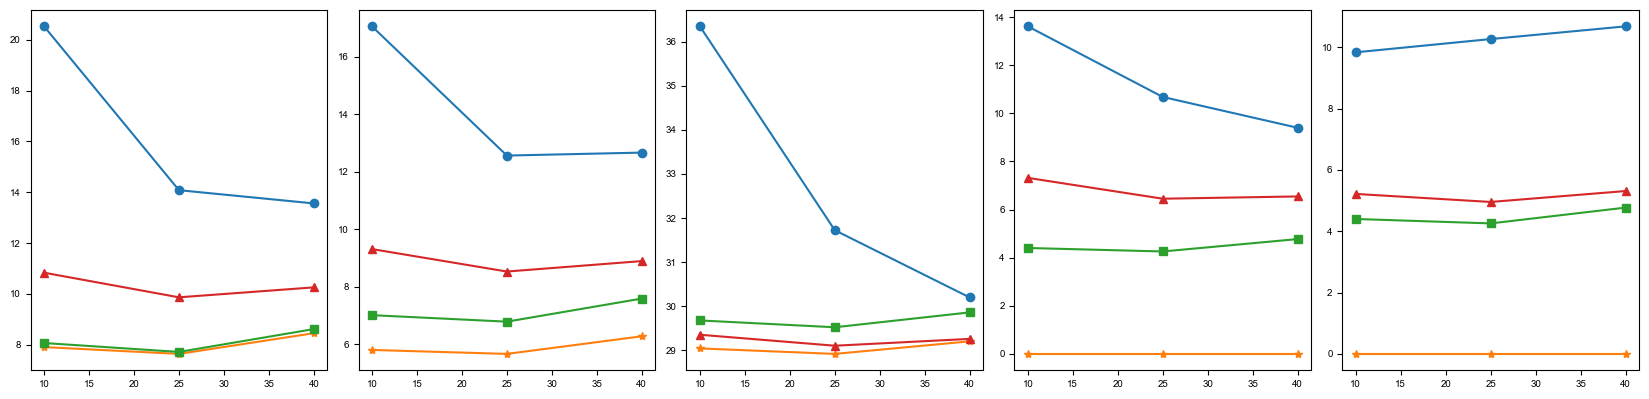

In [22]:
x_0 = 6.366576288
Exp3_exp_at_x_0 = {};            
Exp3_exp_at_x_0["x_0"] = x_0
Exp3_exp_at_x_0["Age_T"] = [10, 25, 40]
keys = ["SOH_loss", "LLI", "Res", "LLI", "LAM_Ne", "LAM_Pe"]
for key in keys:
    Exp3_exp_at_x_0[key] = []

Exp3_SEI_at_x_0 = {};            
Exp3_SEI_at_x_0["x_0"] = x_0
Exp3_SEI_at_x_0["Age_T"] = [10, 25, 40]
keys = ["SOH_loss", "LLI", "Res", "LLI", "LAM_Ne", "LAM_Pe"]
for key in keys:
    Exp3_SEI_at_x_0[key] = []

Exp3_SEIDry_at_x_0 = {};            
Exp3_SEIDry_at_x_0["x_0"] = x_0
Exp3_SEIDry_at_x_0["Age_T"] = [10, 25, 40]
keys = ["SOH_loss", "LLI", "Res", "LLI", "LAM_Ne", "LAM_Pe"]
for key in keys:
    Exp3_SEIDry_at_x_0[key] = []

Exp3_5couple_at_x_0 = {};            
Exp3_5couple_at_x_0["x_0"] = x_0
Exp3_5couple_at_x_0["Age_T"] = [10, 25, 40]
keys = ["SOH_loss", "LLI", "Res",  "LAM_Ne", "LAM_Pe"]
for key in keys:
    Exp3_5couple_at_x_0[key] = []


for i,T_deg in enumerate([10,25,40]):
    Exp_temp_i_cell = Temp_Cell_Exp[str(int(T_deg))]
    XY_pack = Get_Cell_Mean_1T_1Exp(Exp_Any_AllData,Exp_temp_i_cell) 
    [X_1_st,X_5_st,Y_1_st_avg,Y_2_st_avg,
        Y_3_st_avg,Y_4_st_avg,Y_5_st_avg,Y_6_st_avg]  = XY_pack
    
    Exp3_exp_at_x_0["SOH_loss"].append(100-np.interp(x_0, X_1_st, Y_1_st_avg))
    Exp3_exp_at_x_0["LLI"].append(np.interp(x_0, X_1_st, Y_2_st_avg))
    Exp3_exp_at_x_0["Res"].append(np.interp(x_0, X_5_st, Y_5_st_avg))
    Exp3_exp_at_x_0["LAM_Ne"].append(np.interp(x_0, X_1_st, Y_3_st_avg))
    Exp3_exp_at_x_0["LAM_Pe"].append(np.interp(x_0, X_1_st, Y_4_st_avg))

    Exp3_SEI_at_x_0["SOH_loss"].append(100-np.interp(
        x_0, Cases[0][str(T_deg)][0]["Throughput capacity [kA.h]"], 
            np.array(Cases[0][str(T_deg)][0]["CDend SOH [%]"])  )  )
    Exp3_SEI_at_x_0["LLI"].append(np.interp(
        x_0, Cases[0][str(T_deg)][0]["Throughput capacity [kA.h]"], 
            np.array(Cases[0][str(T_deg)][0]["CDend LLI [%]"])  )  )
    Exp3_SEI_at_x_0["Res"].append(np.interp(
        x_0, Cases[0][str(T_deg)][0]["Throughput capacity [kA.h]"], 
            np.array(Cases[0][str(T_deg)][0]["Res_midSOC"])  )  )
    Exp3_SEI_at_x_0["LAM_Ne"].append(np.interp(
        x_0, Cases[0][str(T_deg)][0]["Throughput capacity [kA.h]"], 
            np.array(Cases[0][str(T_deg)][0]["CDend LAM_ne [%]"])  )  )
    Exp3_SEI_at_x_0["LAM_Pe"].append(np.interp(
        x_0, Cases[0][str(T_deg)][0]["Throughput capacity [kA.h]"], 
            np.array(Cases[0][str(T_deg)][0]["CDend LAM_pe [%]"])  )  )

    Exp3_SEIDry_at_x_0["SOH_loss"].append(100-np.interp(
        x_0, Cases[1][str(T_deg)][0]["Throughput capacity [kA.h]"], 
            np.array(Cases[1][str(T_deg)][0]["CDend SOH [%]"])  )  )
    Exp3_SEIDry_at_x_0["LLI"].append(np.interp(
        x_0, Cases[1][str(T_deg)][0]["Throughput capacity [kA.h]"], 
            np.array(Cases[1][str(T_deg)][0]["CDend LLI [%]"])  )  )
    Exp3_SEIDry_at_x_0["Res"].append(np.interp(
        x_0, Cases[1][str(T_deg)][0]["Throughput capacity [kA.h]"], 
            np.array(Cases[1][str(T_deg)][0]["Res_midSOC"])  )  )
    Exp3_SEIDry_at_x_0["LAM_Ne"].append(np.interp(
        x_0, Cases[1][str(T_deg)][0]["Throughput capacity [kA.h]"], 
            np.array(Cases[1][str(T_deg)][0]["CDend LAM_ne [%]"])  )  )
    Exp3_SEIDry_at_x_0["LAM_Pe"].append(np.interp(
        x_0, Cases[1][str(T_deg)][0]["Throughput capacity [kA.h]"], 
            np.array(Cases[1][str(T_deg)][0]["CDend LAM_pe [%]"])  )  )

    Exp3_5couple_at_x_0["SOH_loss"].append(100-np.interp(
        x_0, Cases[2][str(T_deg)][0]["Throughput capacity [kA.h]"], 
            np.array(Cases[2][str(T_deg)][0]["CDend SOH [%]"])  )  )
    Exp3_5couple_at_x_0["LLI"].append(np.interp(
        x_0, Cases[2][str(T_deg)][0]["Throughput capacity [kA.h]"], 
            np.array(Cases[2][str(T_deg)][0]["CDend LLI [%]"])  )  )
    Exp3_5couple_at_x_0["Res"].append(np.interp(
        x_0, Cases[2][str(T_deg)][0]["Throughput capacity [kA.h]"], 
            np.array(Cases[2][str(T_deg)][0]["Res_midSOC"])  )  )
    Exp3_5couple_at_x_0["LAM_Ne"].append(np.interp(
        x_0, Cases[2][str(T_deg)][0]["Throughput capacity [kA.h]"], 
            np.array(Cases[2][str(T_deg)][0]["CDend LAM_ne [%]"])  )  )
    Exp3_5couple_at_x_0["LAM_Pe"].append(np.interp(
        x_0, Cases[2][str(T_deg)][0]["Throughput capacity [kA.h]"], 
            np.array(Cases[2][str(T_deg)][0]["CDend LAM_pe [%]"])  )  )
# interpretate at 6.366576288:
fig, axs = plt.subplots(1,5, figsize=(16.5,4),tight_layout=True) 
for i in range(5):
    axs[i].plot(
        Exp3_exp_at_x_0["Age_T"],Exp3_exp_at_x_0[keys[i]],"-o") 
    axs[i].plot(
        Exp3_exp_at_x_0["Age_T"],Exp3_SEI_at_x_0[keys[i]],"-*") 
    axs[i].plot(
        Exp3_exp_at_x_0["Age_T"],Exp3_SEIDry_at_x_0[keys[i]],"-s") 
    axs[i].plot(
        Exp3_exp_at_x_0["Age_T"],Exp3_5couple_at_x_0[keys[i]],"-^") 

# save
Exp3 = [
    Exp3_exp_at_x_0, Exp3_SEI_at_x_0,
    Exp3_SEIDry_at_x_0, Exp3_5couple_at_x_0
]
""" import pickle
with open(
    SaveFig_Path + f'/T_dependency_Exp3.pkl', 'wb') as file:
    pickle.dump(Exp3, file)
     """

In [23]:
SaveFig_Path

'd:\\lrhwork\\model_rh\\env_pbgem_nc\\SimSave\\Li2024_Results\\SaveFig'

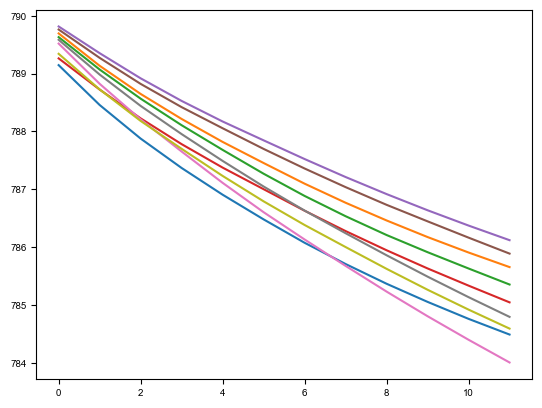

In [24]:
Cases = [SEI_Exp3_GoodFit,SEIDry_Exp3_GoodFit,Full_Exp3_GoodFit]; 
np.diff(Cases[0][str(40)][0]['Throughput capacity [kA.h]'])*1e3
for i in range(3):
    for T_deg in [10,25,40]:
        plt.plot(np.diff(Cases[i][str(T_deg)][0]['Throughput capacity [kA.h]'])*1e3)

In [25]:
# Get DVA 
def Get_DVA(data):
    M = len(data["CD Terminal voltage [V]"])
    data["CD Cap [A.h]"] = [];  data["CD SOC"] = [];
    data["CD dV_dQ_cell [V/Ah]"] = [];  data["CD dV_dQ_an [V/Ah]"] = [];
    data["CD dV_dQ_ca [V/Ah]"] = [];
    for m in range(M):
        V_cell = np.array(data["CD Terminal voltage [V]"][m])
        V_an   = np.array(data["CD Anode potential [V]"][m])
        V_ca   = np.array(data["CD Cathode potential [V]"][m])
        cap_dis= np.array(data["CD Time [h]"][m][-1]) * 0.5  - np.array(data["CD Time [h]"][m]) * 0.5 
        soc_dis= cap_dis / cap_dis[0] * 100
        dV_dQ_cell = np.diff(V_cell) / np.diff(cap_dis)
        dV_dQ_an = np.diff(V_an) / np.diff(cap_dis)
        dV_dQ_ca = np.diff(V_ca) / np.diff(cap_dis)
        data["CD Cap [A.h]"].append(cap_dis)
        data["CD SOC"].append(soc_dis)
        data["CD dV_dQ_cell [V/Ah]"].append(dV_dQ_cell)
        data["CD dV_dQ_an [V/Ah]"].append(dV_dQ_an)
        data["CD dV_dQ_ca [V/Ah]"].append(dV_dQ_ca)
    return data

Cases = [SEI_Exp3_GoodFit,SEIDry_Exp3_GoodFit,Full_Exp3_GoodFit]; 
T_deg_All = ["10","25","40"] 
for i,case_i in enumerate(Cases):
    for T_deg in T_deg_All:
        case_i[T_deg][0]  =  Get_DVA(case_i[T_deg][0])

'     \nplt.savefig(\n    target_folder + f"/Fig.5 - T={T_deg}degC DMA - RPT {m+1}.png", dpi=dpi) \nplt.savefig(\n    target_folder + f"/Fig.5 - T={T_deg}degC DMA - RPT {m+1}.svg")   '

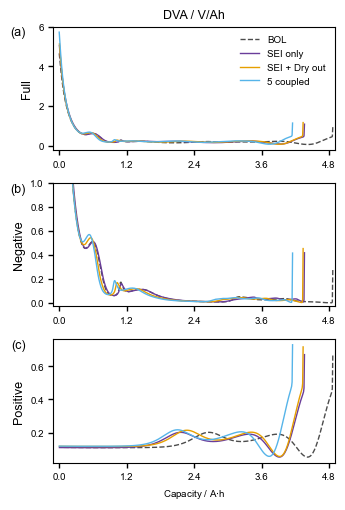

In [26]:
# Fig. 5 compare DVA - 10degC
T_deg = 10; m = 12
color_exp_Avg = [0, 0, 0, 0.7];
#Cases = [SEI_Exp3_GoodFit,SEIDry_Exp3_GoodFit,Full_Exp3_GoodFit]; 
#Cases = [SEI_Exp3_GoodFit,SEIDry_Exp3_GoodFit,Full_Exp3_GoodFit]; 
Str_cases = ["SEI only","SEI + Dry out","5 coupled",]
Y_V_Strs = ["CD Terminal voltage [V]","CD Anode potential [V]", "CD Cathode potential [V]" ]
Y_dV_Strs = ["CD dV_dQ_cell [V/Ah]","CD dV_dQ_an [V/Ah]", "CD dV_dQ_ca [V/Ah]" ]

fig, axs = plt.subplots(3,1, figsize=(8.8/2.54,13/2.54),tight_layout=True)
for j,y_str in enumerate(Y_dV_Strs):
    axs[j].plot(
        Cases[0][str(T_deg)][0]["CD Cap [A.h]"][0][0:-1], 
        abs(Cases[0][str(T_deg)][0][y_str][0]),
        linewidth=ls,  linestyle='--', 
        color = color_exp_Avg ,  label= "BOL" )
    for i,case in enumerate(Cases):
        axs[j].plot(
            case[str(T_deg)][0]["CD Cap [A.h]"][m][0:-1], 
            abs(case[str(T_deg)][0][y_str][m]), 
            linewidth=ls,  linestyle='-',  
            color = cm_4s[i],  label=Str_cases[i])

for nn in range(3):
    axs[nn].set_xlim([-0.1,4.9])
    axs[nn].set_xticks([0,  1.2, 2.4, 3.6, 4.8])
axs[0].set_title("DVA / V/Ah", fontsize=fs+2)
for i,y_title in enumerate(["Full", "Negative", "Positive"]):
    axs[i].set_ylabel(y_title, fontsize=fs+2)
axs[1].set_ylim([-0.03,1.0])
axs[2].set_xlabel(r"Capacity / A$\cdot$h")

for nn in range(3):
    labels = axs[nn].get_xticklabels() + axs[nn].get_yticklabels()
    axs[nn].tick_params(labelcolor='k', labelsize=fs, width=1);del labels  
axs[0].legend(prop={'size':fs},loc='best',frameon=False)
labels = [f"({chr(97 + i)})" for i in range(3)]

for i in range(3):   
    axs[i].text(
        -0.10, 1.0, 
        labels[i], transform=axs[i].transAxes, 
        fontsize=fs+2,  # fontweight='bold', 
        va='top', ha='right')
"""     
plt.savefig(
    target_folder + f"/Fig.5 - T={T_deg}degC DMA - RPT {m+1}.png", dpi=dpi) 
plt.savefig(
    target_folder + f"/Fig.5 - T={T_deg}degC DMA - RPT {m+1}.svg")   """

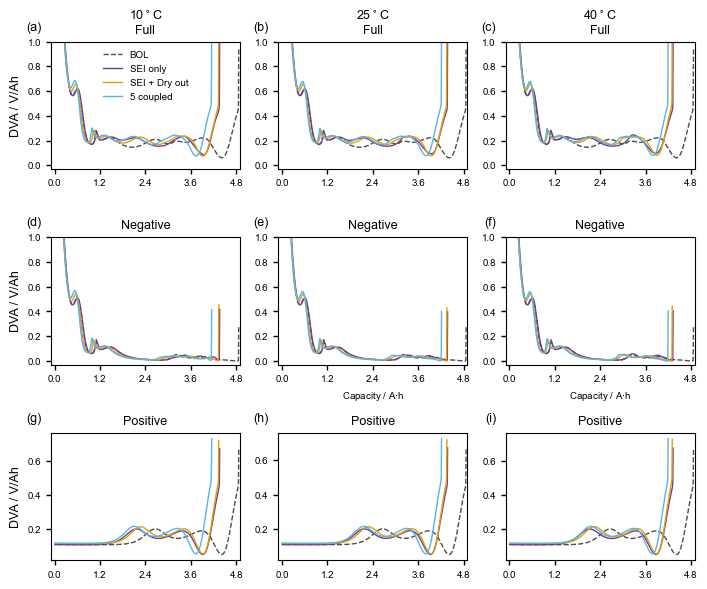

In [27]:
# Fig. S11 compare DVA - 10degC, 25degC and 40degC
m = 12
color_exp_Avg = [0, 0, 0, 0.7];
#Cases = [SEI_Exp3_GoodFit,SEIDry_Exp3_GoodFit,Full_Exp3_GoodFit]; 
#Cases = [SEI_Exp3_GoodFit,SEIDry_Exp3_GoodFit,Full_Exp3_GoodFit]; 
Str_cases = ["SEI only","SEI + Dry out","5 coupled",]
Y_V_Strs = ["CD Terminal voltage [V]","CD Anode potential [V]", "CD Cathode potential [V]" ]
Y_dV_Strs = ["CD dV_dQ_cell [V/Ah]","CD dV_dQ_an [V/Ah]", "CD dV_dQ_ca [V/Ah]" ]
T_degs = [10, 25, 40]
ABC_labels = [f"({chr(97+i)})" for i in range(9)]

fig, Axs = plt.subplots(3,3, figsize=(18/2.54,15/2.54),tight_layout=True)
axs = Axs.flatten()
for k in range(len(T_degs)):
    # 10degC: 0, 3, 6    k=0 
    # 25degC: 1, 4, 7    k=1
    # 40degC: 2, 5, 8    k=2
    for j,y_str in enumerate(Y_dV_Strs):
        axs[3*(j+1)-3+k].plot(
            Cases[0][str(T_degs[k])][0]["CD Cap [A.h]"][0][0:-1], 
            abs(Cases[0][str(T_degs[k])][0][y_str][0]),
            linewidth=ls,  linestyle='--', 
            color = color_exp_Avg ,  label= "BOL" )
        for i,case in enumerate(Cases):
            axs[3*(j+1)-3+k].plot(
                case[str(T_degs[k])][0]["CD Cap [A.h]"][m][0:-1], 
                abs(case[str(T_degs[k])][0][y_str][m]), 
                linewidth=ls,  linestyle='-',  
                color = cm_4s[i],  label=Str_cases[i])

    for nn in range(3):
        axs[3*(nn+1)-3+k].set_xlim([-0.1,4.9])
        axs[3*(nn+1)-3+k].set_xticks([0,  1.2, 2.4, 3.6, 4.8])
    axs[k].set_title(
        f"{T_degs[k]}"+r"$^\circ$C"+"\nFull", 
        fontsize=fs+2)
    
    for nn in range(3):
        labels = axs[3*(nn+1)-3+k].get_xticklabels() + axs[3*(nn+1)-3+k].get_yticklabels()
        axs[3*(nn+1)-3+k].tick_params(
            labelcolor='k', labelsize=fs, width=1)
        del labels  

    for j in range(3):  
        axs[3*(j+1)-3+k].text(
            -0.05, 1.16, 
            ABC_labels[3*(j+1)-3+k], transform=axs[3*(j+1)-3+k].transAxes, 
            fontsize=fs+2,  # fontweight='bold', 
            va='top', ha='right')
for j in range(3):  # enumerate(["Full", "Negative", "Positive"]):
    axs[3*(j+1)-3].set_ylabel('DVA / V/Ah', fontsize=fs+2)
for i in [3,4,5]:
    axs[i].set_title("Negative", fontsize=fs+2)
for i in [6,7,8]:
    axs[i].set_title("Positive", fontsize=fs+2)
for i in range(6):
    axs[i].set_ylim([-0.03,1.0])
axs[4].set_xlabel(r"Capacity / A$\cdot$h")
axs[5].set_xlabel(r"Capacity / A$\cdot$h")
axs[0].legend(prop={'size':fs},loc='best',frameon=False)
plt.subplots_adjust(wspace=0.15, hspace=0.05)
plt.savefig(
    target_folder + f"/Fig. S15 compare DVA-3Ts for Exp-3.png", 
    dpi=dpi) 
plt.savefig(
    target_folder + f"/Fig. S15 compare DVA-3Ts for Exp-3.svg")  

' plt.savefig(\n    target_folder + f"/Fig. S7 SEI_DryOut LLI break down.png", dpi=dpi)\nplt.savefig(\n    target_folder + f"/Fig. S7 SEI_DryOut LLI break down.pdf")   '

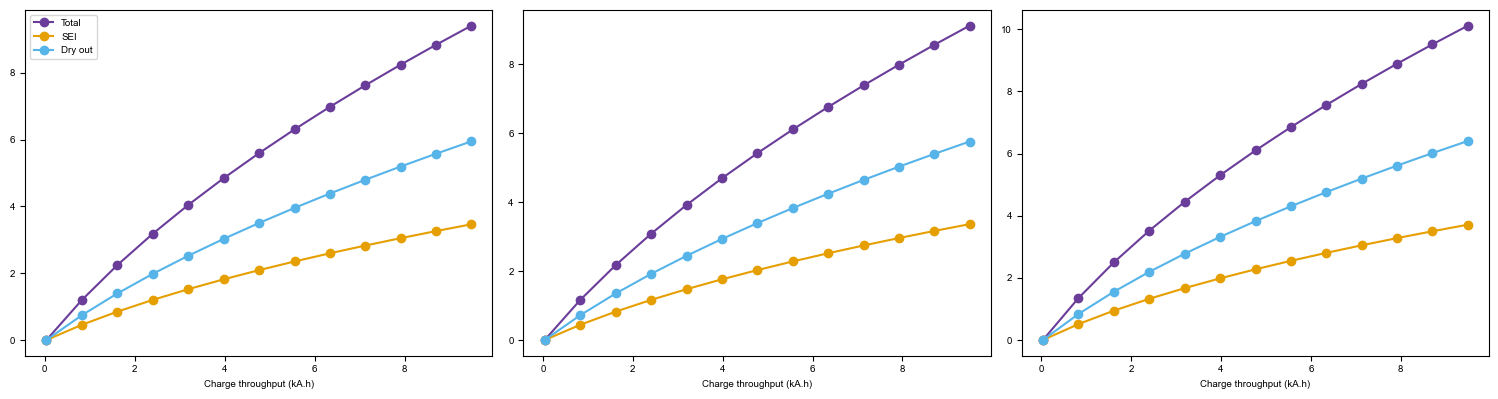

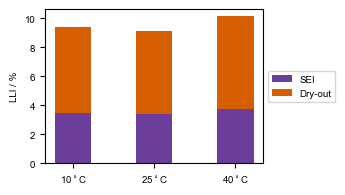

In [28]:
# plot break down of LLI for SEI-dry and Full
# - due to SEI and due to dry-out; 
# - due to SEI, SEI on crack, LiP and dry-out
case = SEIDry_Exp3_GoodFit
LLI_to_SEI_allTs=[]; LLI_to_Dry_allTs =[]
fig, axs = plt.subplots(1,3, figsize=(15,4),tight_layout=True) 
for i,T_deg in enumerate([10,25,40]):
    LLI_to_SEI = (
        np.array(case[str(T_deg)][0]['CDend LLI SEI on cracks [%]'])
        +
        np.array(case[str(T_deg)][0]['CDend LLI SEI [%]']) )
    LLI_to_Dry = (
        np.array(case[str(T_deg)][0]['CDend LLI [%]'])
        -
        LLI_to_SEI)
    LLI_to_SEI_allTs.append(LLI_to_SEI[-1])
    LLI_to_Dry_allTs.append(LLI_to_Dry[-1])
    axs[i].plot(
        case[str(T_deg)][0]['Throughput capacity [kA.h]'], 
        case[str(T_deg)][0]['CDend LLI [%]'], 
        '-o', color = cm_4s[0], label="Total")
    axs[i].plot(
        case[str(T_deg)][0]['Throughput capacity [kA.h]'], 
        LLI_to_SEI, 
        '-o', color = cm_4s[1], label="SEI")
    axs[i].plot(
        case[str(T_deg)][0]['Throughput capacity [kA.h]'], 
        LLI_to_Dry, 
        '-o', color = cm_4s[2], label="Dry out")
    axs[i].set_xlabel("Charge throughput (kA.h)")
axs[0].legend()

# 
fig, ax = plt.subplots(figsize=(8.8/2.54, 5/2.54),tight_layout=True) 
X_labels = (
    r"10$^\circ$C",  #axs[i].set_title(f"T={T_deg}"+r"$^\circ$C")
    r"25$^\circ$C",
    r"40$^\circ$C",
)
LLI_Components = {
    "SEI":     np.array(LLI_to_SEI_allTs),
    "Dry-out": np.array(LLI_to_Dry_allTs),
}
width = 0.45

bottom = np.zeros(3)
i=0
for key, weight_count in LLI_Components.items():
    p = ax.bar(X_labels, weight_count, width, 
               label=key, bottom=bottom,color=cm_4s[i])
    bottom += weight_count
    i += 3

legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_ylabel("LLI / %")
""" plt.savefig(
    target_folder + f"/Fig. S7 SEI_DryOut LLI break down.png", dpi=dpi)
plt.savefig(
    target_folder + f"/Fig. S7 SEI_DryOut LLI break down.pdf")   """

In [29]:
LLI_to_SEI_allTs

[np.float64(3.4658502853764235),
 np.float64(3.3632338002006854),
 np.float64(3.710921359116165)]

' plt.savefig(\n    target_folder + f"/Fig. S8 Full LLI break down.png", dpi=dpi)\nplt.savefig(\n    target_folder + f"/Fig. S8 Full LLI break down.pdf")   '

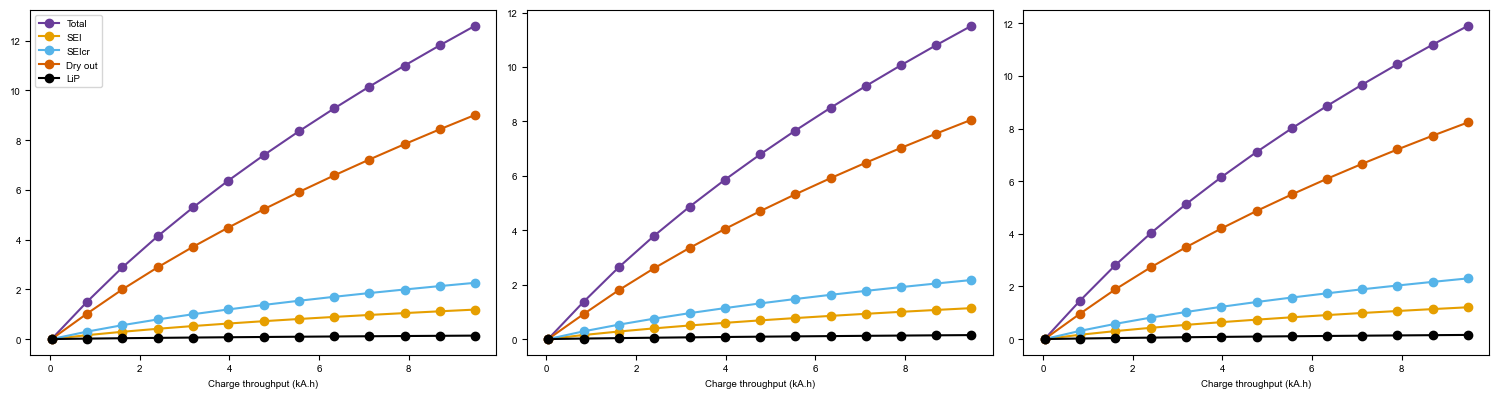

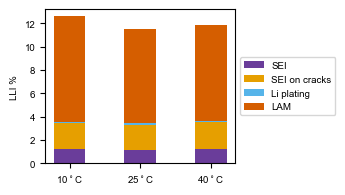

In [30]:
# - LLI  due to SEI, SEI on crack, LiP and dry-out
case = Full_Exp3_GoodFit
LLI_to_SEI_allTs=[];        LLI_to_Dry_allTs =[]; 
LLI_to_SEIcr_allTs = [];    LLI_to_LiP_allTs =[]; 
fig, axs = plt.subplots(1,3, figsize=(15,4),tight_layout=True) 
for i,T_deg in enumerate([10,25,40]):
    LLI_to_SEI = np.array(case[str(T_deg)][0]['CDend LLI SEI [%]'])
    LLI_to_SEIcr = np.array(case[str(T_deg)][0]['CDend LLI SEI on cracks [%]'])
    LLI_to_LiP = np.array(case[str(T_deg)][0]['CDend LLI lithium plating [%]'])
    LLI_to_Dry = (
        np.array(case[str(T_deg)][0]['CDend LLI [%]'])
        -LLI_to_SEI-LLI_to_LiP-LLI_to_SEIcr)
    
    LLI_to_SEI_allTs.append(LLI_to_SEI[-1])
    LLI_to_Dry_allTs.append(LLI_to_Dry[-1])
    LLI_to_SEIcr_allTs.append(LLI_to_SEIcr[-1])
    LLI_to_LiP_allTs.append(LLI_to_LiP[-1])
    axs[i].plot(
        case[str(T_deg)][0]['Throughput capacity [kA.h]'], 
        case[str(T_deg)][0]['CDend LLI [%]'], 
        '-o', color = cm_4s[0], label="Total")
    axs[i].plot(
        case[str(T_deg)][0]['Throughput capacity [kA.h]'], 
        LLI_to_SEI, 
        '-o', color = cm_4s[1], label="SEI")
    axs[i].plot(
        case[str(T_deg)][0]['Throughput capacity [kA.h]'], 
        LLI_to_SEIcr, 
        '-o', color = cm_4s[2], label="SEIcr")
    axs[i].plot(
        case[str(T_deg)][0]['Throughput capacity [kA.h]'], 
        LLI_to_Dry, 
        '-o', color = cm_4s[3], label="Dry out")
    axs[i].plot(
        case[str(T_deg)][0]['Throughput capacity [kA.h]'], 
        LLI_to_LiP, 
        '-o', color = "k", label="LiP")
    axs[i].set_xlabel("Charge throughput (kA.h)")
axs[0].legend()

# 
fig, ax = plt.subplots(figsize=(8.8/2.54, 5/2.54),tight_layout=True) 
X_labels = (
    r"10$^\circ$C",  #axs[i].set_title(f"T={T_deg}"+r"$^\circ$C")
    r"25$^\circ$C",
    r"40$^\circ$C",
)
LLI_Components = {
    "SEI":     np.array(LLI_to_SEI_allTs),
    "SEI on cracks":     np.array(LLI_to_SEIcr_allTs),
    "Li plating":     np.array(LLI_to_LiP_allTs),
    "LAM": np.array(LLI_to_Dry_allTs),
}
width = 0.45

bottom = np.zeros(3)
i=0
for key, weight_count in LLI_Components.items():
    p = ax.bar(X_labels, weight_count, width, label=key, bottom=bottom,color=cm_4s[i])
    bottom += weight_count
    i += 1

legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_ylabel("LLI %")
""" plt.savefig(
    target_folder + f"/Fig. S8 Full LLI break down.png", dpi=dpi)
plt.savefig(
    target_folder + f"/Fig. S8 Full LLI break down.pdf")   """

In [31]:
LAM_to_Dry   = 100-np.array(case[str(T_deg)][2]['Width_all'])/case[str(T_deg)][2]['Width_all'][0]*100
print(LAM_to_Dry)

[0.         0.         0.83586941 0.90948066 1.64481132 1.71407597
 2.37082655 2.43703966 3.03540391 3.09934724 3.65216011 3.71434417
 4.2303181  4.2910951  4.77647593 4.83609996 5.29554725 5.35420908
 5.79130845 5.84915612 6.26674348 6.32389416 6.72425402 6.78080425
 7.16581387]


[np.float64(3.0070185204440225), np.float64(2.0748228881702975), np.float64(1.666896909978723)]
[np.float64(6.217248937900877e-15), np.float64(6.217248937900877e-15), np.float64(2.3092638912203256e-14)]
[np.float64(7.05898038317973), np.float64(6.725146022959521), np.float64(7.165813869092418)]


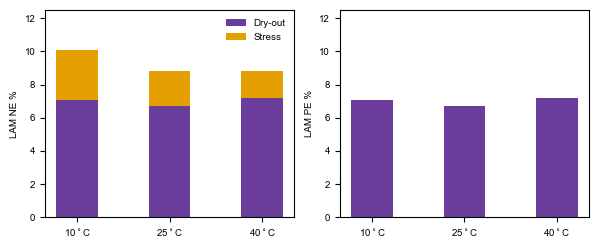

In [32]:
# plot break down of LAM for Full 
# LAM - due to cracking; due to dry-out
case = Full_Exp3_GoodFit
LAM_to_Crack_NE_allTs=[];        LAM_to_Dry_allTs =[];  LAM_to_Crack_PE_allTs=[];  

for i,T_deg in enumerate([10,25,40]):
    LAM_to_Dry   = 100-np.array(case[str(T_deg)][2]['Width_all'])/case[str(T_deg)][2]['Width_all'][0]*100

    LAM_to_Dry_allTs.append(LAM_to_Dry[-1])
    LAM_to_Crack_NE_allTs.append(case[str(T_deg)][0]['CDend LAM_ne [%]'][-1]-LAM_to_Dry[-1])
    LAM_to_Crack_PE_allTs.append(case[str(T_deg)][0]['CDend LAM_pe [%]'][-1]-LAM_to_Dry[-1])
print(LAM_to_Crack_NE_allTs)
print(LAM_to_Crack_PE_allTs)
print(LAM_to_Dry_allTs)
LAM_NE_Components = {
    "Dry-out": np.array(LAM_to_Dry_allTs),
    "Stress":     np.array(LAM_to_Crack_NE_allTs),}
LAM_PE_Components = {
    "Dry-out": np.array(LAM_to_Dry_allTs),
    "Stress":     np.array(LAM_to_Crack_PE_allTs),}
Labels = ["LAM NE %","LAM PE %"]
fig, axs = plt.subplots(1,2, figsize=(6,2.5),tight_layout=True) 
width = 0.45

LAM_Components_All = [LAM_NE_Components,LAM_PE_Components]
for k,LAM_Components in enumerate(LAM_Components_All):
    i=0;  bottom = np.zeros(3)
    for key, weight_count in LAM_Components.items():
        p = axs[k].bar(
            X_labels, weight_count, width, label=key, 
            bottom=bottom,color=cm_4s[i])
        bottom += weight_count
        i += 1
    axs[k].set_ylim(0,12.5) # Labels
    axs[k].set_ylabel(Labels[k])
legend = axs[0].legend(loc='best',frameon=False)
plt.savefig(
    target_folder + f"/Full LAM break down.png", dpi=dpi)
plt.savefig(
    target_folder + f"/Full LAM break down.svg") 

T=40
SEI only
3.23
3.72
41.77
100.00
100.00
32.30
SEI + Dry out
3.19
1.86
32.95
52.93
53.35
19.23
5 coupled
1.98
3.51
22.93
37.03
49.17
15.07


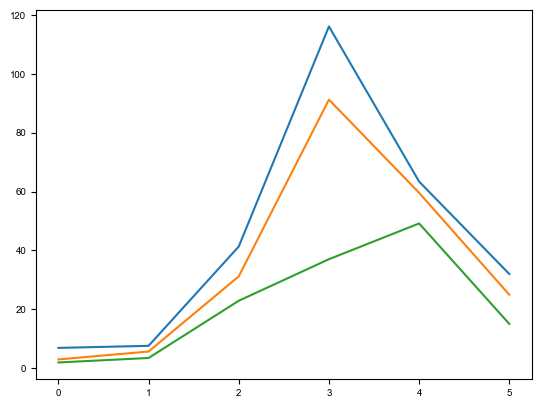

In [33]:
##### Evaluate errors:
# now compare SOH, resistance, and T rise

Cases = [SEI_Exp3_GoodFit,SEIDry_Exp3_GoodFit,Full_Exp3_GoodFit]; Str_cases = ["SEI only","SEI + Dry out","5 coupled",]
# [0,0] --> [0]; [1,1] --> [1]; [1,2] --> [2]
# [0,1] --> [0]; [0,2] --> [1]; [1,0] --> [2]


def Calculate_MPE_re(Temp_Cell_Exp,T_deg,case_i):

    Exp_temp_i_cell = Temp_Cell_Exp[str(int(T_deg))]
    XY_pack = Get_Cell_Mean_1T_1Exp(Exp_Any_AllData,Exp_temp_i_cell) 
    [X_1_st,X_5_st,Y_1_st_avg,Y_2_st_avg,
        Y_3_st_avg,Y_4_st_avg,Y_5_st_avg,Y_6_st_avg]  = XY_pack
    for cell in Exp_temp_i_cell:
        df = Exp_Any_AllData[cell]["Extract Data"]
        chThr_temp = np.array(df["Charge Throughput (A.h)"])/1e3
        df_DMA = Exp_Any_AllData[cell]["DMA"]["LLI_LAM"]

    for cell in Exp_temp_i_cell:
        df = Exp_Any_AllData[cell]["Extract Data"]
        chThr_temp = np.array(df["Charge Throughput (A.h)"])/1e3
        df_DMA = Exp_Any_AllData[cell]["DMA"]["LLI_LAM"]
    # model results
    my_dict_RPT =  case_i[str(T_deg)][0]
    mX_1 = my_dict_RPT['Throughput capacity [kA.h]']
    if mX_1[-1] > X_1_st[-1]:
        punish = 1; 
        mX_1_st = X_1_st   # do interpolation on modelling result
        mY_1_st = np.interp(mX_1_st,my_dict_RPT['Throughput capacity [kA.h]'], 
            my_dict_RPT['CDend SOH [%]'])
        mY_2_st = np.interp(mX_1_st,my_dict_RPT['Throughput capacity [kA.h]'], 
            my_dict_RPT["CDend LLI [%]"])
        mY_3_st = np.interp(mX_1_st,my_dict_RPT['Throughput capacity [kA.h]'], 
            my_dict_RPT["CDend LAM_ne [%]"])
        mY_4_st = np.interp(mX_1_st,my_dict_RPT['Throughput capacity [kA.h]'], 
            my_dict_RPT["CDend LAM_pe [%]"])
        mY_6_st = np.interp(mX_1_st,my_dict_RPT['Throughput capacity [kA.h]'], 
            my_dict_RPT["avg_Age_T"])
        # experiment result remain unchanged
        Y_1_st_avgm = np.array(Y_1_st_avg)
        Y_2_st_avgm = np.array(Y_2_st_avg)
        Y_3_st_avgm = np.array(Y_3_st_avg)
        Y_4_st_avgm = np.array(Y_4_st_avg)
        Y_6_st_avgm = np.array(Y_6_st_avg)
    else:                # do interpolation on expeirment results
        punish = X_1_st[-1] / mX_1[-1]  # punishment error, add when simulation end early
        mX_1_st = mX_1 #  standard for experiment following modelling
        Y_1_st_avgm = np.interp(mX_1_st,X_1_st,Y_1_st_avg)
        Y_2_st_avgm = np.interp(mX_1_st,X_1_st,Y_2_st_avg)
        Y_3_st_avgm = np.interp(mX_1_st,X_1_st,Y_3_st_avg)
        Y_4_st_avgm = np.interp(mX_1_st,X_1_st,Y_4_st_avg)
        Y_6_st_avgm = np.interp(mX_1_st,X_1_st,Y_6_st_avg)
        mY_1_st = np.array(my_dict_RPT['CDend SOH [%]'])
        mY_2_st = np.array(my_dict_RPT["CDend LLI [%]"])
        mY_3_st = np.array(my_dict_RPT["CDend LAM_ne [%]"])
        mY_4_st = np.array(my_dict_RPT["CDend LAM_pe [%]"])
        mY_6_st = np.array(my_dict_RPT["avg_Age_T"])
    if mX_1[-1] > X_5_st[-1]:
        mX_5_st = X_5_st   
        mY_5_st = np.interp(mX_5_st,my_dict_RPT['Throughput capacity [kA.h]'], 
            my_dict_RPT["Res_midSOC"])
        Y_5_st_avgm = np.array(Y_5_st_avg)
    else:
        mX_5_st = mX_1 #  standard for experiment following modelling
        mY_5_st = np.array(my_dict_RPT["Res_midSOC"])
        Y_5_st_avgm = np.interp(mX_5_st,X_5_st,Y_5_st_avg).tolist()
    # Now we can calculate MPE! mean_percentage_error
    mpe_1 = mean_percentage_error(Y_1_st_avgm, mY_1_st) # SOH [%]
    mpe_2 = mean_percentage_error(Y_2_st_avgm, mY_2_st) # LLI [%]
    mpe_3 = mean_percentage_error(Y_3_st_avgm, mY_3_st) # LAM_ne [%]
    mpe_4 = mean_percentage_error(Y_4_st_avgm, mY_4_st) # LAM_pe [%]
    mpe_5 = mean_percentage_error(Y_5_st_avgm, mY_5_st) # Res_midSOC
    mpe_6 = mean_percentage_error(Y_6_st_avgm, mY_6_st) # Age set average temperature (degC)
    # total MPE: TODO this is where weighting works
    # SOH and Resistance are directly measured so give more weight; 
    # DMA result is derived from pOCV and come with certain errors
    mpe_tot = 0.5* mpe_1 + 0.125* (mpe_2+mpe_3+mpe_4+mpe_5)
    mpe_pack = [mpe_1,mpe_5,mpe_2,mpe_3,mpe_4,mpe_tot]

    
    return mpe_pack

Exp_Any_AllData = Exp_3_AllData;  
Temp_Cell_Exp = Temp_Cell_Exp_All[index_exp-1] 
T_deg_All = [10,25,40] 

MPE_All = {}
for i,case in enumerate(Cases):
    MPE_All[Str_cases[i]] = []
for i,case in enumerate(Cases):
    for T_deg in T_deg_All:
        MPE_All[Str_cases[i]].append(Calculate_MPE_re(Temp_Cell_Exp,T_deg,case))
#print(MPE_All)
i=2
plt.plot(MPE_All[Str_cases[i]][0]) # T=10
plt.plot(MPE_All[Str_cases[i]][1]) # T=25
plt.plot(MPE_All[Str_cases[i]][2]) # T=25
# for 10degC:
j = 2
print(f"T={T_deg_All[j]}")
for i in range(3):
    print(Str_cases[i])
    for value in MPE_All[Str_cases[i]][j]:
        print(f"{value:.2f}")

